# Step 1: Signal Leakage Identificatio

Data loaded successfully from: /Users/goyolozano/Desktop/Mini 4/Value/Update 2/final_clean_data.parquet
Data shape: (648349, 34)

Defining target variable 'default_label'...
Target variable 'default_label' created.
default_label
0    0.814544
1    0.185456
Name: proportion, dtype: float64

Using 33 features for initial leakage check model.

Setting up preprocessing pipeline...
Identified 6 categorical features.
Identified 27 numerical features.

Splitting data into training and test sets...
Train set shape: X=(453844, 33), y=(453844,)
Test set shape: X=(194505, 33), y=(194505,)

Training Logistic Regression model (expect high performance due to leakage)...
Model training completed.

Evaluating model performance on the test set (expect high Accuracy and AUC):
Accuracy: 0.9979
AUC Score: 0.9996

Classification Report:
              precision    recall  f1-score   support

 Non-Default       1.00      1.00      1.00    158433
     Default       1.00      0.99      0.99     36072

    accu

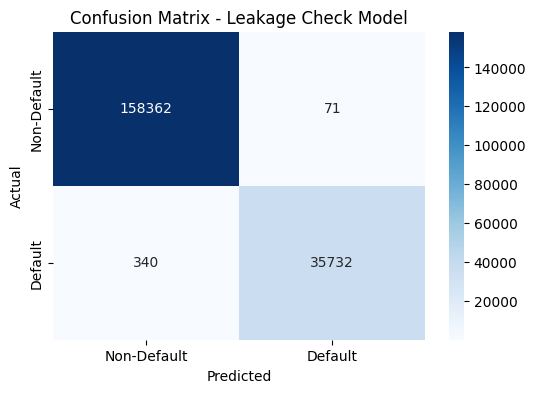

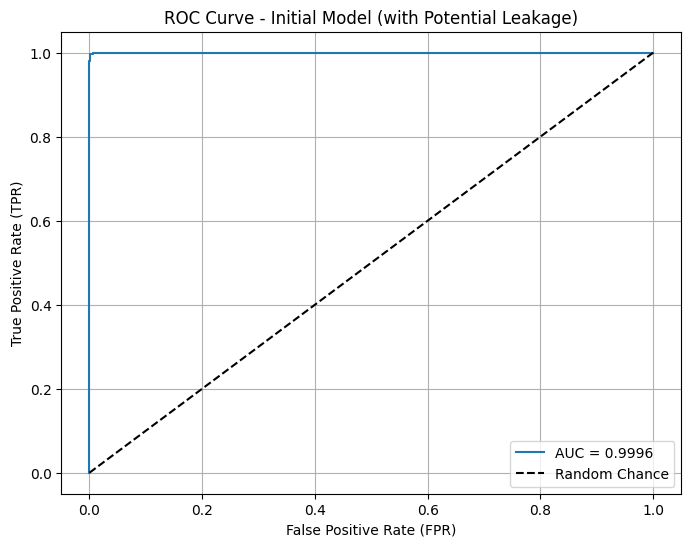


--- Identifying and Confirming Leakage Variables ---
High AUC (0.9996) confirms signal leakage is present.
Manual review based on data dictionary and business logic is required.
Identify variables known *only after* the loan outcome (e.g., payments, recoveries).

Confirmed Leakage Variables (to be excluded in subsequent models):
- total_pymnt
- recoveries
- ret_PESS
- ret_OPT
- ret_INTa
- ret_INTb
- ret_INTc

ACTION: Exclude these variables from feature sets for predictive investment models.


In [ ]:
# Signal Leakage Identification

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "/Users/goyolozano/Desktop/Mini 4/Value/Update 2/final_clean_data.parquet"
try:
    final_clean_data = pd.read_parquet(file_path)
    print(f"Data loaded successfully from: {file_path}")
    print(f"Data shape: {final_clean_data.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"ERROR loading data: {e}")
    exit()

#  Define Target Variable
print("\nDefining target variable 'default_label'...")
default_statuses = ['Charged Off', 'Default']
if 'loan_status' in final_clean_data.columns:
    final_clean_data['default_label'] = final_clean_data['loan_status'].apply(
        lambda x: 1 if x in default_statuses else 0
    )
    print("Target variable 'default_label' created.")
    print(final_clean_data['default_label'].value_counts(normalize=True))
else:
    print("ERROR: 'loan_status' column not found. Cannot create target variable.")
    exit()

# Leakage Check
# Use all columns except the target variable itself and its direct source
all_columns = final_clean_data.columns.tolist()
# Define features potentially known only *after* the loan outcome
known_leakage_candidates = [
    'total_pymnt', 'recoveries', 'ret_PESS', 'ret_OPT',
    'ret_INTa', 'ret_INTb', 'ret_INTc', 'loan_length'
]

features_to_exclude_initially = ['default_label', 'loan_status']
leakage_check_features = [
    col for col in all_columns if col not in features_to_exclude_initially
]
print(f"\nUsing {len(leakage_check_features)} features for initial leakage check model.")

X = final_clean_data[leakage_check_features].copy()
y = final_clean_data['default_label']

# Preprocessing
print("\nSetting up preprocessing pipeline...")
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Ensure all features are covered
assert set(categorical_features + numerical_features) == set(leakage_check_features)
print(f"Identified {len(categorical_features)} categorical features.")
print(f"Identified {len(numerical_features)} numerical features.")

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Train/Test Split
print("\nSplitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Train set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

# --- 1.6 Train Leakage Check Model ---
print("\nTraining Logistic Regression model (expect high performance due to leakage)...")
model_pipeline_leakage = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV(
        cv=5, penalty='l2', solver='lbfgs', max_iter=1000,
        random_state=42, scoring='roc_auc', n_jobs=-1
    ))
])

try:
    model_pipeline_leakage.fit(X_train, y_train)
    print("Model training completed.")
except Exception as e:
    print(f"ERROR during model fitting: {e}")
    exit()

# Leakage Check Model
print("\nEvaluating model performance on the test set (expect high Accuracy and AUC):")
try:
    y_pred_leakage = model_pipeline_leakage.predict(X_test)
    y_proba_leakage = model_pipeline_leakage.predict_proba(X_test)[:, 1]

    accuracy_leakage = accuracy_score(y_test, y_pred_leakage)
    auc_leakage = roc_auc_score(y_test, y_proba_leakage)
    cm_leakage = confusion_matrix(y_test, y_pred_leakage) # Calculate confusion matrix HERE

    print(f"Accuracy: {accuracy_leakage:.4f}")
    print(f"AUC Score: {auc_leakage:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_leakage, target_names=["Non-Default", "Default"]))

    print("\nConfusion Matrix:")
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_leakage, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix - Leakage Check Model')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba_leakage)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_leakage:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve - Initial Model (with Potential Leakage)")
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"ERROR during model evaluation: {e}")

# Confirm Leakage and Define Exclusions ---
print("\n--- Identifying and Confirming Leakage Variables ---")

if 'auc_leakage' in locals() and auc_leakage > 0.95: # Using a high threshold
    print(f"High AUC ({auc_leakage:.4f}) confirms signal leakage is present.")
    print("Manual review based on data dictionary and business logic is required.")
    print("Identify variables known *only after* the loan outcome (e.g., payments, recoveries).")


    confirmed_leakage_variables = [
        'total_pymnt',   # Known only after payments are made/loan completes
        'recoveries',    # Known only after default and recovery efforts
        'ret_PESS',      # Calculated return, depends on final outcome
        'ret_OPT',       # Calculated return, depends on final outcome
        'ret_INTa',      # Calculated return, depends on final outcome
        'ret_INTb',      # Calculated return, depends on final outcome
        'ret_INTc'       # Calculated return, depends on final outcome
    ]

    confirmed_leakage_variables = [var for var in confirmed_leakage_variables if var in all_columns]

    print("\nConfirmed Leakage Variables (to be excluded in subsequent models):")
    if confirmed_leakage_variables:
        for var in confirmed_leakage_variables:
            print(f"- {var}")
    else:
        print("None confirmed (review needed).")

    print("\nACTION: Exclude these variables from feature sets for predictive investment models.")

else:
    print("AUC score is not high enough to definitively confirm leakage via this model alone.")
    print("Manual review of features based on the data dictionary is still recommended.")
    confirmed_leakage_variables = []


# Step 2: Model with Grade and Interest Rate Only


Model with Grade and Interest Rate Only
Selected features: ['grade', 'int_rate']

Setting up preprocessing pipeline for Step 2...
Preprocessing pipeline defined.

Splitting data for Step 2...
Step 2 Train set shape: X=(453844, 2), y=(453844,)
Step 2 Test set shape: X=(194505, 2), y=(194505,)

Training Logistic Regression model using only Grade and Interest Rate...
Model training completed.

Evaluating Step 2 model performance on the test set:
Accuracy: 0.8146
AUC Score: 0.6849

Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.81      1.00      0.90    158433
     Default       0.65      0.00      0.00     36072

    accuracy                           0.81    194505
   macro avg       0.73      0.50      0.45    194505
weighted avg       0.78      0.81      0.73    194505


Confusion Matrix:


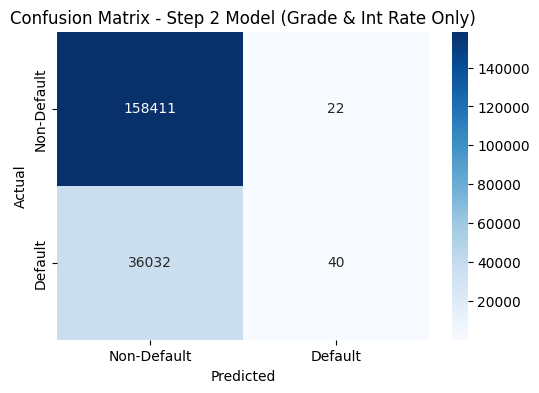

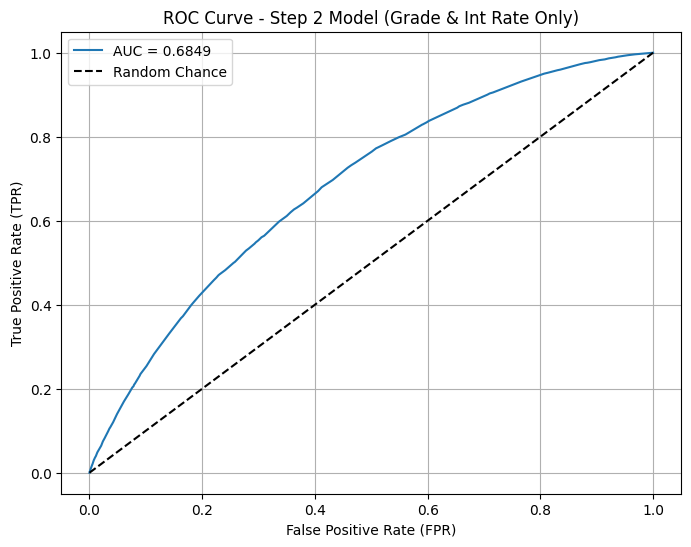


--- Step 2 Complete ---


In [ ]:
# Model with Grade and Interest Rate Only

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns


# Features and Target
print("\nModel with Grade and Interest Rate Only")
features_step2 = ['grade', 'int_rate']
target_step2 = 'default_label'

if not all(f in final_clean_data.columns for f in features_step2):
    print(f"ERROR: Required columns {features_step2} not found in DataFrame.")
    exit()
if target_step2 not in final_clean_data.columns:
    print(f"ERROR: Target column '{target_step2}' not found.")
    exit()

X_step2 = final_clean_data[features_step2].copy()
y_step2 = final_clean_data[target_step2]

print(f"Selected features: {features_step2}")

# Preprocessing for Selected Features
print("\nSetting up preprocessing pipeline for Step 2...")
# Define transformers specifically for these features
numerical_transformer_step2 = Pipeline(steps=[
    ('scaler', StandardScaler()) #
])

categorical_transformer_step2 = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create ColumnTransformer
preprocessor_step2 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_step2, ['int_rate']),
        ('cat', categorical_transformer_step2, ['grade'])
    ],
    remainder='passthrough'
)
print("Preprocessing pipeline defined.")

# Train/Test Split
print("\nSplitting data for Step 2...")
X_train_step2, X_test_step2, y_train_step2, y_test_step2 = train_test_split(
    X_step2, y_step2, test_size=0.3, random_state=42, stratify=y_step2
)
print(f"Step 2 Train set shape: X={X_train_step2.shape}, y={y_train_step2.shape}")
print(f"Step 2 Test set shape: X={X_test_step2.shape}, y={y_test_step2.shape}")

# Logistic Regression Model
print("\nTraining Logistic Regression model using only Grade and Interest Rate...")
model_pipeline_step2 = Pipeline(steps=[
    ('preprocessor', preprocessor_step2),
    ('classifier', LogisticRegressionCV(
        cv=5, penalty='l2', solver='lbfgs', max_iter=1000,
        random_state=42, scoring='roc_auc', n_jobs=-1
     ))
])

try:
    model_pipeline_step2.fit(X_train_step2, y_train_step2)
    print("Model training completed.")
except Exception as e:
    print(f"ERROR during model fitting: {e}")
    exit()

# Model Performance
print("\nEvaluating Step 2 model performance on the test set:")
try:
    y_pred_step2 = model_pipeline_step2.predict(X_test_step2)
    y_proba_step2 = model_pipeline_step2.predict_proba(X_test_step2)[:, 1]

    accuracy_step2 = accuracy_score(y_test_step2, y_pred_step2)
    auc_step2 = roc_auc_score(y_test_step2, y_proba_step2)
    cm_step2 = confusion_matrix(y_test_step2, y_pred_step2)

    print(f"Accuracy: {accuracy_step2:.4f}")
    print(f"AUC Score: {auc_step2:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test_step2, y_pred_step2, target_names=["Non-Default", "Default"]))

    print("\nConfusion Matrix:")
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_step2, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix - Step 2 Model (Grade & Int Rate Only)')
    plt.show()

    # ROC Curve
    fpr_step2, tpr_step2, _ = roc_curve(y_test_step2, y_proba_step2)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_step2, tpr_step2, label=f"AUC = {auc_step2:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve - Step 2 Model (Grade & Int Rate Only)")
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"ERROR during model evaluation: {e}")

print("\n--- Step 2 Complete ---")

# Step 3: Downsampling

In [ ]:
# Downsampling
from imblearn.under_sampling import RandomUnderSampler

all_columns_step3 = final_clean_data.columns.tolist()

variables_to_exclude = ['default_label', 'loan_status'] + confirmed_leakage_variables

# Features for modeling (non-leaky features available before/at investment)
modeling_features = [
    col for col in all_columns_step3 if col not in variables_to_exclude
]
print(f"\nUsing {len(modeling_features)} features before resampling.")

if not modeling_features:
    print("ERROR: No modeling features remaining after exclusions.")
    exit()

X_model = final_clean_data[modeling_features].copy()
y_model = final_clean_data['default_label']


# Train/Test Split (Using NON-Leakage Features)
# Perform split BEFORE resampling
X_train, X_test, y_train, y_test = train_test_split(
    X_model, y_model, test_size=0.3, random_state=42, stratify=y_model
)

print("\nOriginal training data distribution:")
print(y_train.value_counts(normalize=True))
print(f"Shape of X_train (before resampling): {X_train.shape}")
print(f"Shape of X_test (will not be resampled): {X_test.shape}")


# Apply Downsampling to Training Data Only
under_sampler = RandomUnderSampler(random_state=42)

print("\nApplying RandomUnderSampler to the training data...")
try:
    # Resample BOTH X and y training sets
    X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)
    print("Downsampling complete.")
except Exception as e:
    print(f"ERROR during downsampling: {e}")
    exit()

print("\nResampled training data distribution:")
print(y_train_resampled.value_counts(normalize=True))
print(f"Shape of X_train_resampled: {X_train_resampled.shape}") #
print(f"Shape of y_train_resampled: {y_train_resampled.shape}")


Using 26 features before resampling.

Original training data distribution:
default_label
0    0.814544
1    0.185456
Name: proportion, dtype: float64
Shape of X_train (before resampling): (453844, 26)
Shape of X_test (will not be resampled): (194505, 26)

Applying RandomUnderSampler to the training data...
Downsampling complete.

Resampled training data distribution:
default_label
0    0.5
1    0.5
Name: proportion, dtype: float64
Shape of X_train_resampled: (168336, 26)
Shape of y_train_resampled: (168336,)


# Step 4: Feature Selection & Models

Defining feature set for Step 4 (excluding grade, int_rate, leakage)...
Using 23 features for Step 4 models:
Step 4 Train shapes: X=(168336, 23), y=(168336,)
Step 4 Test shapes: X=(194505, 23), y=(194505,)

Defining preprocessing pipeline for Step 4 features...
Preprocessing pipeline defined.

--- Training Decision Tree Model (Step 4 Features) ---
Running GridSearchCV for Decision Tree...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Decision Tree parameters found: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 200}
Best CV ROC AUC score: 0.6562

 Training Logistic Regression Model (Step 4)
Fitting Logistic Regression CV model...
Logistic Regression training complete.

Step 4 Rationale
Feature Set: Models in this step used only features available at application time.
Excluded Features: 'grade', 'int_rate', 'loan_length' (Lending Club/derived signals), and leakage variables (['total_pymnt', 'recoveries', 'ret_PESS', 

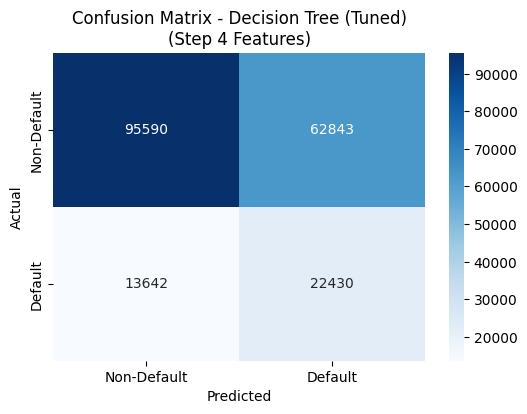

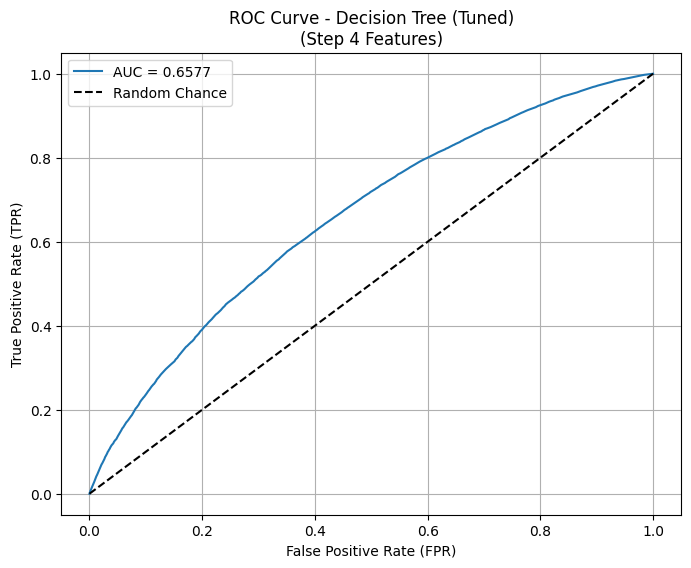


--- Evaluating Logistic Regression (CV) ---
Accuracy: 0.6525
AUC Score: 0.6827

Classification Report:
              precision    recall  f1-score   support

 Non-Default       0.88      0.67      0.76    158433
     Default       0.29      0.60      0.39     36072

    accuracy                           0.65    194505
   macro avg       0.58      0.63      0.57    194505
weighted avg       0.77      0.65      0.69    194505


Confusion Matrix:


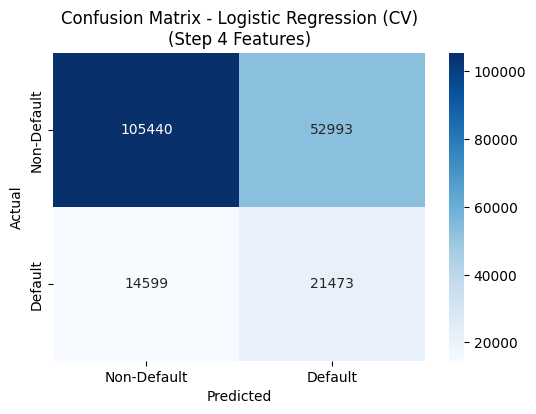

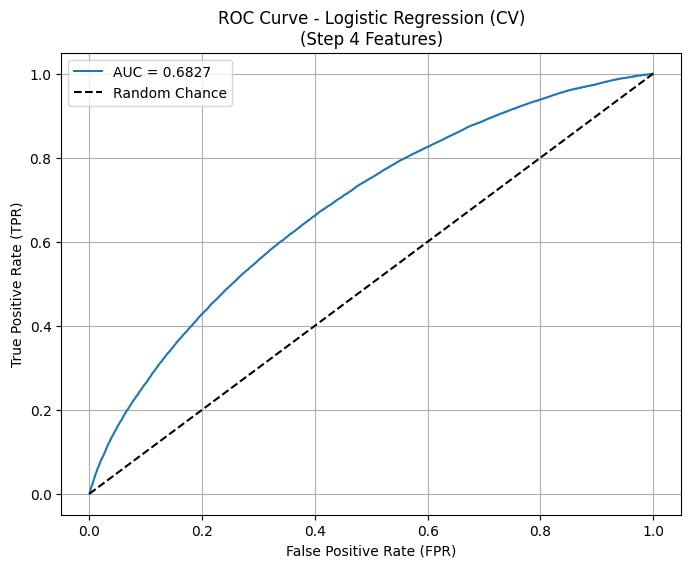

In [ ]:
# Feature Selection & Models (Application-Time Variables Only)

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("Defining feature set for Step 4 (excluding grade, int_rate, leakage)...")
if 'X_train_resampled' not in locals() or 'confirmed_leakage_variables' not in locals():
     print("ERROR: Prerequisite data (X_train_resampled or confirmed_leakage_variables) not found.")
     print("Please ensure Steps 1-3 have been run successfully.")
     exit()

step4_features_columns = X_train_resampled.columns.tolist()
features_to_exclude_step4 = ['grade', 'int_rate', 'loan_length'] + confirmed_leakage_variables

step4_modeling_features = [
    col for col in step4_features_columns if col not in features_to_exclude_step4
]

if not step4_modeling_features:
    print("ERROR: No modeling features remain for Step 4 after exclusions!")
    exit()

print(f"Using {len(step4_modeling_features)} features for Step 4 models:")


# Create the specific training and test sets for this step
X_train_step4 = X_train_resampled[step4_modeling_features].copy()
X_test_step4 = X_test[step4_modeling_features].copy()

y_train_step4 = y_train_resampled.copy()
y_test_step4 = y_test.copy() # Use the original y_test

print(f"Step 4 Train shapes: X={X_train_step4.shape}, y={y_train_step4.shape}")
print(f"Step 4 Test shapes: X={X_test_step4.shape}, y={y_test_step4.shape}")

# Preprocessing for Step 4
print("\nDefining preprocessing pipeline for Step 4 features...")
categorical_features_step4 = X_train_step4.select_dtypes(include=['object', 'category', 'boolean']).columns.tolist()
numerical_features_step4 = X_train_step4.select_dtypes(include=np.number).columns.tolist()

# Ensure all features are covered
try:
    assert set(categorical_features_step4 + numerical_features_step4) == set(step4_modeling_features)
except AssertionError:
    print("WARNING: Feature types might not cover all selected Step 4 features.")
    print("Categorical:", categorical_features_step4)
    print("Numerical:", numerical_features_step4)
    print("All Step 4:", step4_modeling_features)


numerical_transformer_step4 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer_step4 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Or strategy='constant', fill_value='missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_step4 = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_step4, numerical_features_step4),
        ('cat', categorical_transformer_step4, categorical_features_step4)
    ],
    remainder='passthrough'
)
print("Preprocessing pipeline defined.")

# --- 4.3: Train Decision Tree Model ---
print("\n--- Training Decision Tree Model (Step 4 Features) ---")
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor_step4),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define hyperparameter grid for tuning
# Keep the grid small initially for faster execution, expand if needed
param_grid_dt = {
    'classifier__max_depth': [5, 10, 15], # Reduced options for speed
    'classifier__min_samples_leaf': [50, 100, 200], # Adjusted options
    'classifier__criterion': ['gini', 'entropy']
}

# Use GridSearchCV to find best parameters based on ROC AUC score
search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

print("Running GridSearchCV for Decision Tree...")
best_dt_model = None # Initialize
try:
    search_dt.fit(X_train_step4, y_train_step4)
    print(f"Best Decision Tree parameters found: {search_dt.best_params_}")
    print(f"Best CV ROC AUC score: {search_dt.best_score_:.4f}")
    best_dt_model = search_dt.best_estimator_
except Exception as e:
    print(f"ERROR during Decision Tree GridSearchCV: {e}")


# Train Logistic Regression Model
print("\n Training Logistic Regression Model (Step 4)")
pipeline_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor_step4),
    ('classifier', LogisticRegressionCV(
        cv=5,
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        scoring='roc_auc',
        n_jobs=-1
     ))
])

print("Fitting Logistic Regression CV model...")
try:
    pipeline_logreg.fit(X_train_step4, y_train_step4)
    print("Logistic Regression training complete.")
except Exception as e:
    print(f"ERROR during Logistic Regression fitting: {e}")
    pipeline_logreg = None

# Rationale & Considerations
print("\nStep 4 Rationale")
print("Feature Set: Models in this step used only features available at application time.")
print(f"Excluded Features: 'grade', 'int_rate', 'loan_length' (Lending Club/derived signals), and leakage variables ({confirmed_leakage_variables}).")
print("Purpose: To establish baseline predictive performance based solely on borrower-provided information.")
print("Model Considerations:")
print("- Decision Trees: Less sensitive to multicollinearity, can capture non-linear interactions.")
print("- Logistic Regression: Assumes linear relationship (log-odds), can be sensitive to multicollinearity (L2 regularization helps mitigate).")
print("NOTE: For actual investment prediction (later steps), excluded features like 'grade' and 'int_rate' CAN be added back.")

# Evaluate Models on Test Set
print("\nEvaluating Step 4 Models on Original Test Set")

models_step4 = {}
if best_dt_model: models_step4['Decision Tree (Tuned)'] = best_dt_model
if pipeline_logreg: models_step4['Logistic Regression (CV)'] = pipeline_logreg

results_step4 = {}

if not models_step4:
    print("ERROR: No models were successfully trained in Step 4. Cannot evaluate.")
else:
    for model_name, model_pipeline in models_step4.items():
        print(f"\n--- Evaluating {model_name} ---")
        try:
            y_pred = model_pipeline.predict(X_test_step4)
            y_proba = model_pipeline.predict_proba(X_test_step4)[:, 1]

            accuracy = accuracy_score(y_test_step4, y_pred)
            auc = roc_auc_score(y_test_step4, y_proba)
            report = classification_report(y_test_step4, y_pred, target_names=["Non-Default", "Default"])
            cm = confusion_matrix(y_test_step4, y_pred)

            # Store results
            results_step4[model_name] = {'AUC': auc, 'Accuracy': accuracy, 'Report': report, 'CM': cm, 'Pipeline': model_pipeline}

            # Print results
            print(f"Accuracy: {accuracy:.4f}")
            print(f"AUC Score: {auc:.4f}")
            print("\nClassification Report:")
            print(report)

            print("\nConfusion Matrix:")
            plt.figure(figsize=(6,4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.title(f'Confusion Matrix - {model_name}\n(Step 4 Features)')
            plt.show()

            # Plot ROC Curve
            fpr, tpr, _ = roc_curve(y_test_step4, y_proba)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
            plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
            plt.xlabel("False Positive Rate (FPR)")
            plt.ylabel("True Positive Rate (TPR)")
            plt.title(f"ROC Curve - {model_name}\n(Step 4 Features)")
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"ERROR during evaluation of {model_name}: {e}")
            results_step4[model_name] = {'Error': str(e)}


# Step 5: Decision Tree Result Explanation

Now that we've removed the leakage, we get a more realistic picture of the model's performance:

Overall Performance: The AUC score is 0.6553. This is noticeably lower than the score from the model with leakage (which was ~0.78), as expected. It indicates the model has some ability to distinguish between defaulting and non-defaulting loans, but it's only moderately better than random guessing (AUC 0.5). The overall accuracy is 60.0%.
Class-Specific Performance:
Finding Defaults (Recall): The model finds 63% of the actual defaults. So, it catches a majority, but misses over a third of them.
Accuracy when Predicting Default (Precision): When the model predicts a loan will default, it's only correct 26% of the time. This is quite low and means there are still many "false alarms" many loans flagged as potential defaults would likely have paid back fine (the Confusion Matrix shows 64,435 False Positives vs 22,696 True Positives).
Accuracy when Predicting Non-Default (Precision): The model is much better here. When it predicts a loan won't default, it's correct 88% of the time.
How does it make decisions? (Top Rules)

Based on the rules extracted from this valid tree:

* Is it a 60-month loan? (cat_term_36 months <= 0.50): The most important factor the tree now uses is the loan term. It first separates the 60-month loans from the 36-month loans.
* What is the Total Bankcard Limit? (num_total_bc_limit): For both 36-month and 60-month loans, the next crucial question involves the borrower's total credit limit across their credit cards. The tree uses different thresholds (based on the scaled value) depending on the loan term.
* Other Factors: Further down the decision paths, the tree considers combinations of:
Home Ownership Status (e.g., cat_home_ownership_RENT).
Debt-to-Income Ratio (num_dti).
Number of Mortgage Accounts (num_mort_acc).
Income Verification Status (e.g., cat_verification_status_Not Verified).


In simple terms:
This (valid) Decision Tree primarily uses the loan term (36 vs 60 months) and the applicant's overall credit card limit to make its first broad judgments about default risk. It then refines these predictions by looking at their housing situation (renting vs. owning/mortgage), their debt load relative to income, and whether their income source was verified. The model's performance is modest (AUC~0.66), catching many defaults but struggling with precision (many false alarms)

# Step 6: Logistic Regresion Results

Here's a summary of its performance on the test data:

Overall Performance: The AUC score is 0.6827. This is slightly better than the valid Decision Tree model (which had AUC ~0.66) and indicates a modest ability to differentiate between defaulting and non-defaulting loans - better than chance, but not highly accurate. The overall accuracy is 65.25%.
Class-Specific Performance:
Finding Defaults (Recall): The model identifies 60% of the loans that actually defaulted. This is slightly lower than the Decision Tree's recall for defaults.
Accuracy when Predicting Default (Precision): When this model predicts 'Default', it is correct 29% of the time. This is still low (meaning many "false alarms" - 52,993 false positives according to the confusion matrix), but slightly better than the Decision Tree's precision of 26%.
Accuracy when Predicting Non-Default (Precision): Like the Decision Tree, this model is good here. When it predicts 'Non-Default', it's right 88% of the time.
What drives the model's predictions? (Top Coefficients)

Logistic Regression assigns a "coefficient" (a weight) to each feature. A positive coefficient increases the calculated odds of default, while a negative one decreases it. Here are the features with the biggest impact (largest absolute coefficients) in your model:

Increases Odds of Default:

installment (Coefficient: 1.38): Higher monthly payments are strongly associated with higher predicted default odds. This is the most impactful feature.
term_num / cat_term_60 months (Coeffs: 0.56/0.29): A longer loan term (60 months) increases the odds of default compared to 36 months.
cat_purpose_small_business (Coeff: 0.35): Loans for small businesses are seen as riskier by the model.
cat_emp_length_ (Coeff: 0.34): This likely represents missing or 'n/a' employment length, which increases predicted odds.
num_dti (Coeff: 0.16): A higher debt-to-income ratio increases the odds.
cat_home_ownership_RENT (Coeff: 0.14): Renting increases odds compared to other ownership types (like having a mortgage, which had a negative coefficient).
Decreases Odds of Default:

loan_amnt / funded_amnt (Coeffs: -0.71): Interestingly, higher loan amounts decrease the predicted odds of default in this model. (This might seem counter-intuitive; perhaps larger loans are only approved for applicants the model deems significantly less risky based on other factors).
cat_term_36 months (Coeff: -0.24): Confirms that shorter terms decrease odds relative to longer ones.
cat_purpose_credit_card / cat_purpose_car (Coeffs: -0.22/-0.20): Loans for credit card refinancing or cars appear less risky than the baseline or other purposes.
num_total_bc_limit (Coeff: -0.17): Having a higher total credit card limit decreases the odds, possibly indicating better creditworthiness.
cat_home_ownership_MORTGAGE (Coeff: -0.14): Having a mortgage decreases the odds compared to other types (especially renting).
In simple terms:

The Logistic Regression model predicts default risk based on a combination of factors. Higher monthly payments, longer terms, and loans for small businesses tend to increase the predicted risk. Conversely, factors like larger loan amounts (in this model's view), higher credit card limits, having a mortgage, and shorter terms tend to decrease the predicted risk. Its overall predictive ability (AUC~0.68) is modest and slightly better than the Decision Tree, but it still generates many false alarms when predicting defaults.



# Step 7: Model Comparison and Hypothesis Evalaution

**Collective Insights from Models**

* **Modest Performance:** Both models showed that predicting default accurately using only application data is challenging[cite: 321]. The AUC scores (0.655 for Decision Tree, 0.683 for Logistic Regression) are better than random guessing but not exceptional[cite: 322].
* **Precision vs. Recall Trade-off:** Both models struggled with Precision when predicting 'Default' (correct only 26-29% of the time), meaning many false alarms[cite: 323]. They were better at Recall (finding 60-63% of actual defaults)[cite: 324]. Both were highly precise (88%) when predicting 'Non-Default'[cite: 324].
* **Key Feature Types:** Loan term, borrower debt (DTI), credit capacity/history (total bankcard limit), and personal circumstances (home ownership, possibly employment length or verification status) emerged as relevant predictors in both models[cite: 325].

**Hypothesis Evaluation** [cite: 326]

Let's revisit the hypotheses from Update 1:

1.  *"Loans with higher grades (A, B) will have lower default rates & better returns compared to lower grades (E, F)."*
    * Evaluation: Supported by EDA. Although grade was excluded from the Step 4 models, the analysis in Update 1 strongly confirmed this relationship[cite: 327].
2.  *"Higher interest rates are associated with higher default rates."*
    * Evaluation: Not tested by these models[cite: 328]. `int_rate` was excluded in Step 4[cite: 329]. This hypothesis remains untested by these specific models but is generally expected to be true[cite: 329].
3.  *"A higher debt-to-income ratio increases the likelihood of default."*
    * Evaluation: Supported[cite: 330]. Both the Decision Tree (using `dti` in splits) and Logistic Regression (positive coefficient for `num_dti`) indicated higher DTI increases risk[cite: 331].
4.  *"Higher annual income will be inversely related to default rates."*
    * Evaluation: Supported[cite: 332]. The Logistic Regression showed higher `annual_inc` slightly decreased predicted default odds (negative coefficient)[cite: 333].
5.  *"A higher number of delinquencies will correlate with a higher default rate."*
    * Evaluation: Weakly supported / Uncertain[cite: 334]. Logistic Regression showed a positive coefficient for `delinq_2yrs`, aligning with the hypothesis, but its impact seemed small compared to other features in the model[cite: 335].

**Model Comparison: Decision Tree vs. Logistic Regression** [cite: 336]

* **Performance:** Logistic Regression had slightly better overall metrics (AUC: 0.683 vs 0.655; Accuracy: 65.3% vs 60.0%)[cite: 336]. It had slightly better Precision for defaults (29% vs 26%), while the Decision Tree had slightly better Recall for defaults (63% vs 60%)[cite: 337].
* **Error Types:** The Decision Tree resulted in fewer False Negatives (missing actual defaults: 13,376) but many more False Positives (wrongly flagging good loans: 64,435)[cite: 338]. Logistic Regression had more False Negatives (14,599) but fewer False Positives (52,993)[cite: 339].
* **Interpretability:** Simple Decision Tree rules can be easier to grasp than Logistic Regression coefficients (log-odds)[cite: 340].

**Which Model to Choose? (Revised based on Error Costs)** [cite: 341]

Considering that for an investor like Jasmin, losing invested capital (a False Negative error) is likely much more costly than missing an investment opportunity (a False Positive error), minimizing False Negatives becomes crucial[cite: 341].

The Decision Tree achieved a higher Recall for the 'Default' class (0.63 vs. 0.60), resulting in fewer False Negatives (13,376 vs. 14,599)[cite: 343]. This benefit comes at the cost of significantly more False Positives (missing good opportunities)[cite: 344].

**Revised Choice:** Given the likely higher cost of False Negatives in this investment context, the **Decision Tree** is arguably the better choice for this specific step's goal (predicting default using only application data)[cite: 345].
**Justification:** We prioritize minimizing capital loss[cite: 346]. The Decision Tree better identifies loans that would actually default (higher Recall, lower FN), reducing the risk of investing in bad loans based on the model's prediction[cite: 346]. While this leads to more missed opportunities (higher FP), prioritizing capital preservation aligns well with a prudent investment strategy, making the Decision Tree's trade-off potentially more desirable here[cite: 347].
Step 8: (Optional) Add Additional Models

# Step 9: Decide on Return Method

We chose to focus on the **intermediate return method (`ret_INTb`)** because it offers a realistic balance between the overly pessimistic and overly optimistic ways of calculating returns[cite: 348]. This method assumes that any repayments are immediately reinvested at a fixed interest rate (0.0025 for `ret_INTb`) over a set period, smoothing out differences between loans repaid early versus those running their full term[cite: 349].

For context on how the methods differ[cite: 350]:

* The pessimistic method (`ret_PESS`) annualizes returns over the entire original loan term, essentially treating early repayments as if the money were left idle[cite: 350].
* The optimistic method (`ret_OPT`) annualizes returns based on the actual period the loan was active, assuming immediate reinvestment at the potentially high original rate[cite: 351].
* The intermediate methods (`ret_INTa/b/c`) compute the return over a fixed investment horizon by reinvesting cash flows at predetermined modest rates (0.001, 0.0025, or 0.005 respectively)[cite: 352].

By selecting `ret_INTb` (using the middle reinvestment rate of 0.0025), we adopt an approach that aims to neither severely underestimate gains from good loans nor overstate losses from defaulted loans[cite: 353]. This provides a balanced and practical estimate, reflecting a plausible reinvestment scenario, and serves as a sound basis for predicting which loans are likely to yield good returns[cite: 354].

# Step 10: Predicting Returns using Application-Time Features

Target variable: ret_INTb
Using 23 application-time features.

Splitting data for regression task...
Regression Train set shape: X=(453844, 23), y=(453844,)
Regression Test set shape: X=(194505, 23), y=(194505,)

Defining preprocessing pipeline for regression...
Regression: Identified 5 categorical features.
Regression: Identified 18 numerical features.
Preprocessing pipeline defined.

Training and Evaluating Regularized Regression Models

Training and Evaluating RidgeCV


/Users/goyolozano/Desktop/Mini 4/Value/Update 2/bvenv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


RidgeCV training complete.

RidgeCV Test Set Performance (Features: Application-Time):
R-squared (R²): 0.0135
Mean Squared Error (MSE): 0.0035
Mean Absolute Error (MAE): 0.0385
Best alpha found by RidgeCV: 1000.000000


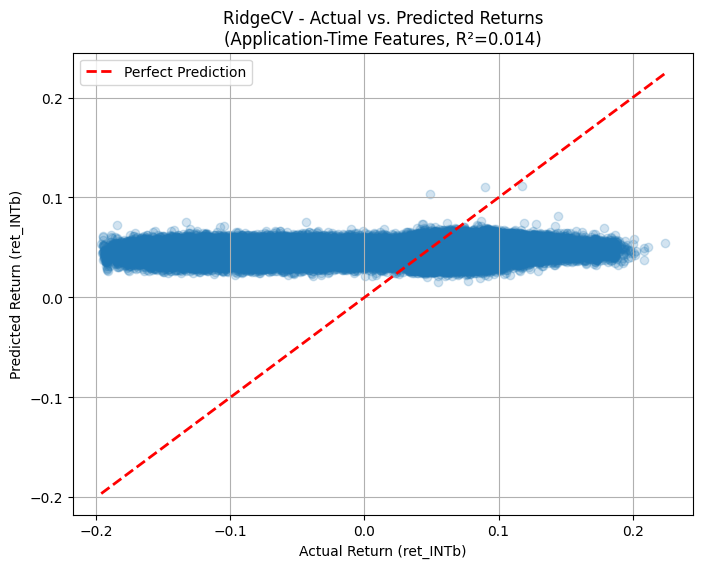


Training and Evaluating LassoCV
LassoCV training complete.

LassoCV Test Set Performance (Features: Application-Time):
R-squared (R²): 0.0135
Mean Squared Error (MSE): 0.0035
Mean Absolute Error (MAE): 0.0385
Best alpha found by LassoCV: 0.000005


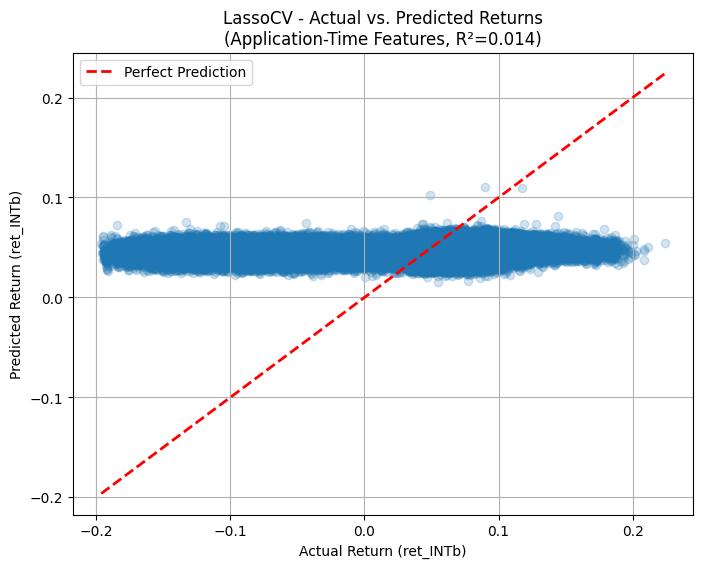


Training and Evaluating ElasticNetCV
ElasticNetCV training complete.

ElasticNetCV Test Set Performance (Features: Application-Time):
R-squared (R²): 0.0135
Mean Squared Error (MSE): 0.0035
Mean Absolute Error (MAE): 0.0385
Best alpha found by ElasticNetCV: 0.000100
Best l1_ratio found by ElasticNetCV: 0.10


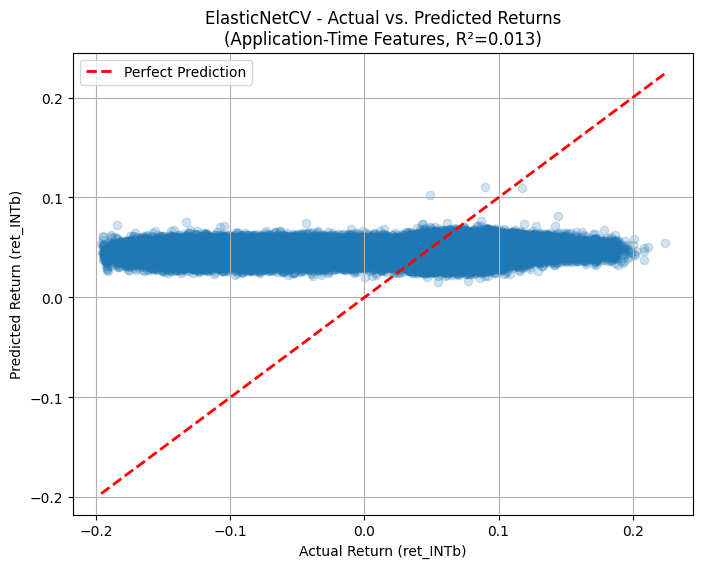

In [ ]:
# Predicting Returns using Application-Time Features

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns


target_variable_reg = 'ret_INTb'

if 'step4_modeling_features' not in locals():
    print("ERROR: 'step4_modeling_features' list not found. Please run Step 4 first.")
    exit()
features_reg = step4_modeling_features

print(f"Target variable: {target_variable_reg}")
print(f"Using {len(features_reg)} application-time features.")

# Ensure target exists in the main DataFrame
if target_variable_reg not in final_clean_data.columns:
    print(f"ERROR: Target variable '{target_variable_reg}' not found in DataFrame.")
    exit()
# Ensure all features exist
if not all(f in final_clean_data.columns for f in features_reg):
     print(f"ERROR: Not all required features found in DataFrame.")
     missing_f = [f for f in features_reg if f not in final_clean_data.columns]
     print("Missing features:", missing_f)
     exit()

# Select data using the application-time features
X_reg = final_clean_data[features_reg].copy()
y_reg = final_clean_data[target_variable_reg].copy()

# Train/Test Split for Regression
print("\nSplitting data for regression task...")
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)
print(f"Regression Train set shape: X={X_train_reg.shape}, y={y_train_reg.shape}")
print(f"Regression Test set shape: X={X_test_reg.shape}, y={y_test_reg.shape}")

# Define Preprocessing Pipeline for Application-Time Features
print("\nDefining preprocessing pipeline for regression...")

# Identify feature types based on the regression training set
categorical_features_reg = X_train_reg.select_dtypes(include=['object', 'category', 'boolean']).columns.tolist()
numerical_features_reg = X_train_reg.select_dtypes(include=np.number).columns.tolist()

print(f"Regression: Identified {len(categorical_features_reg)} categorical features.")
print(f"Regression: Identified {len(numerical_features_reg)} numerical features.")

# Create transformers
numerical_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer_reg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create the preprocessor ColumnTransformer
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_reg, numerical_features_reg),
        ('cat', categorical_transformer_reg, categorical_features_reg)
    ],
    remainder='passthrough'
)
print("Preprocessing pipeline defined.")

# Define, Train, and Evaluate Regularized Regression Models
print("\nTraining and Evaluating Regularized Regression Models")

alphas_ridge = np.logspace(-4, 6, 11) # Example range for Ridge/ElasticNet
alphas_lasso = np.logspace(-6, 1, 11) # Example range for Lasso (often needs smaller alphas)

ridge_model = RidgeCV(alphas=alphas_ridge, store_cv_values=True)
lasso_model = LassoCV(alphas=alphas_lasso, cv=5, random_state=42, max_iter=10000, n_jobs=-1)
elasticnet_model = ElasticNetCV(alphas=alphas_ridge, l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                                cv=5, random_state=42, max_iter=10000, n_jobs=-1)

models_to_run = {
    "RidgeCV": ridge_model,
    "LassoCV": lasso_model,
    "ElasticNetCV": elasticnet_model
}

results_reg = {}

for model_name, model in models_to_run.items():
    print(f"\nTraining and Evaluating {model_name}")

    # Create the full pipeline: Preprocessor + Model
    pipeline_reg = Pipeline(steps=[
        ('preprocessor', preprocessor_reg),
        ('regressor', model)
    ])

    try:
        # Train the pipeline
        pipeline_reg.fit(X_train_reg, y_train_reg)
        print(f"{model_name} training complete.")

        # Make predictions on the test set
        y_pred_reg = pipeline_reg.predict(X_test_reg)

        # Evaluate performance
        r2 = r2_score(y_test_reg, y_pred_reg)
        mse = mean_squared_error(y_test_reg, y_pred_reg)
        mae = mean_absolute_error(y_test_reg, y_pred_reg)

        # Store results
        results_reg[model_name] = {'R2': r2, 'MSE': mse, 'MAE': mae, 'Pipeline': pipeline_reg}

        # Print results
        print(f"\n{model_name} Test Set Performance (Features: Application-Time):")
        print(f"R-squared (R²): {r2:.4f}") # Expect low R-squared
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")

        # Display best alpha/l1_ratio found by CV models
        fitted_regressor = pipeline_reg.named_steps['regressor']
        if hasattr(fitted_regressor, 'alpha_'):
            print(f"Best alpha found by {model_name}: {fitted_regressor.alpha_:.6f}")
        if hasattr(fitted_regressor, 'l1_ratio_') and isinstance(fitted_regressor, ElasticNetCV):
            print(f"Best l1_ratio found by {model_name}: {fitted_regressor.l1_ratio_:.2f}")

        # Optional: Scatter plot of Actual vs Predicted
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test_reg, y_pred_reg, alpha=0.2) # Use lower alpha for dense plots
        plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2, label='Perfect Prediction')
        plt.xlabel("Actual Return (ret_INTb)")
        plt.ylabel("Predicted Return (ret_INTb)")
        plt.title(f"{model_name} - Actual vs. Predicted Returns\n(Application-Time Features, R²={r2:.3f})")
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"ERROR during {model_name} processing: {e}")
        results_reg[model_name] = {'Error': str(e)}

# Step 11 Remianing Strategies

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from sklearn.base import clone

N_LOANS_TO_PICK = 100
CHOSEN_RETURN_COLUMN = 'ret_INTb'


print("Defining helper function: calculate_average_return...")

def calculate_average_return(selected_ids, actual_returns_data, strategy_name=""):
    """
    Calculates the average actual return for a list of selected loan IDs.

    Args:
        selected_ids (list, np.ndarray, pd.Index): A collection of loan IDs selected by the strategy.
        actual_returns_data (pd.Series or pd.DataFrame): Contains actual returns, indexed by loan ID.
                                                        If DataFrame, must contain CHOSEN_RETURN_COLUMN.
        strategy_name (str): Optional name of the strategy for log messages.

    Returns:
        float: The average actual return, or numpy.nan if calculation fails.
    """
    # Ensure selected_ids is a list-like structure and not empty
    if not isinstance(selected_ids, (list, np.ndarray, pd.Index)) or len(selected_ids) == 0:
        print(f"Warning ({strategy_name}): No loans selected or invalid selected_ids type, cannot calculate average return.")
        return np.nan

    # Ensure actual_returns_data is usable
    if actual_returns_data is None or actual_returns_data.empty:
        print(f"ERROR ({strategy_name}): actual_returns_data is None or empty.")
        return np.nan

    # Ensure selected_ids is Index for efficient intersection
    selected_ids_index = pd.Index(selected_ids)

    # Check if actual_returns_data is a Series or DataFrame
    if isinstance(actual_returns_data, pd.DataFrame):
        global CHOSEN_RETURN_COLUMN
        if CHOSEN_RETURN_COLUMN not in actual_returns_data.columns:
            print(f"ERROR ({strategy_name}): Return column '{CHOSEN_RETURN_COLUMN}' not found in actual_returns_data DataFrame.")
            return np.nan
        target_returns_series = actual_returns_data[CHOSEN_RETURN_COLUMN]
    elif isinstance(actual_returns_data, pd.Series):
        target_returns_series = actual_returns_data
    else:
        print(f"ERROR ({strategy_name}): actual_returns_data is not a pandas Series or DataFrame.")
        return np.nan

    # Find IDs present in both selected list and returns data index
    valid_ids = selected_ids_index.intersection(target_returns_series.index)

    if len(valid_ids) == 0:
        print(f"Warning ({strategy_name}): None of the {len(selected_ids_index)} selected IDs were found in the actual returns data index.")
        return np.nan

    try:
        # Select the returns for the valid chosen loan IDs
        relevant_returns = target_returns_series.loc[valid_ids]
        # Calculate the mean return
        average_return = relevant_returns.mean()
        return average_return
    except Exception as e:
        print(f"Error ({strategy_name}) during average return calculation: {e}")
        return np.nan

# Actual Test Returns
print(f"Extracting actual test returns for column: '{CHOSEN_RETURN_COLUMN}'...")
y_test_actual_returns = None
if 'X_test' in locals() and 'final_clean_data' in locals():
    try:
        y_test_actual_returns = final_clean_data.loc[X_test.index, CHOSEN_RETURN_COLUMN].copy()
        print(f"Successfully created y_test_actual_returns with shape: {y_test_actual_returns.shape}")
        # Basic sanity check on returns data
        print(f"Sample actual returns (first 5): \n{y_test_actual_returns.head()}")
        print(f"Actual returns description:\n{y_test_actual_returns.describe()}")
    except KeyError:
        print(f"ERROR: Column '{CHOSEN_RETURN_COLUMN}' not found in final_clean_data. Cannot create y_test_actual_returns.")
    except Exception as e:
        print(f"ERROR creating y_test_actual_returns: {e}")
else:
    print("ERROR: 'X_test' or 'final_clean_data' not found. Cannot create y_test_actual_returns.")

# Initialize results storage
strategy_results = {} # Stores selected IDs
performance_summary = {} # Stores calculated average returns


Defining helper function: calculate_average_return...
Extracting actual test returns for column: 'ret_INTb'...
Successfully created y_test_actual_returns with shape: (194505,)
Sample actual returns (first 5): 
32081     0.074956
54025     0.072783
355292    0.050801
615040    0.065355
405124    0.105277
Name: ret_INTb, dtype: float64
Actual returns description:
count    194505.000000
mean          0.044907
std           0.059304
min          -0.196152
25%           0.043349
50%           0.056454
75%           0.072959
max           0.209550
Name: ret_INTb, dtype: float64


In [ ]:
# Investment Data Prep & Preprocessing

# Initialize variables for this chunk
investment_features_list = []
X_train_invest, X_test_invest = None, None
X_train_invest_resampled, y_train_invest_resampled = None, None
preprocessor_invest = None

# Define Investment-Time Features
if 'modeling_features' in locals() and isinstance(modeling_features, list) and 'final_clean_data' in locals():
    print("Defining investment-time features...")
    investment_features_list = list(modeling_features)
    lc_signals = ['grade', 'int_rate'] # Add others if desired
    for signal in lc_signals:
        if signal not in investment_features_list and signal in final_clean_data.columns:
             investment_features_list.append(signal)
    if 'confirmed_leakage_variables' in locals():
         investment_features_list = [f for f in investment_features_list if f not in confirmed_leakage_variables]
    investment_features_list = [f for f in investment_features_list if f not in ['default_label', 'loan_status']]
    print(f"Defined {len(investment_features_list)} investment-time features.")
else:
    print("ERROR: 'modeling_features' or 'final_clean_data' not found. Cannot define investment features.")

# Prepare Training/Test Data with Investment Features
if investment_features_list and 'X_train' in locals() and 'X_test' in locals():
    print("Creating investment feature sets (X_train_invest, X_test_invest)...")
    missing_train = [f for f in investment_features_list if f not in X_train.columns]
    missing_test = [f for f in investment_features_list if f not in X_test.columns]
    if missing_train or missing_test:
         print(f"ERROR: Missing investment features in X_train: {missing_train}")
         print(f"ERROR: Missing investment features in X_test: {missing_test}")
    else:
        try:
            X_train_invest = X_train[investment_features_list].copy()
            X_test_invest = X_test[investment_features_list].copy()
            print(f"Created Investment Feature Sets: X_train_invest {X_train_invest.shape}, X_test_invest {X_test_invest.shape}")
        except Exception as e:
            print(f"ERROR creating investment feature sets: {e}")
            X_train_invest, X_test_invest = None, None # Reset on error
else:
    if not investment_features_list: print("ERROR: Cannot create feature sets because investment_features_list is empty.")
    if 'X_train' not in locals() or 'X_test' not in locals(): print("ERROR: X_train or X_test from Step 3 not found.")

# Downsampling to Investment Training Data
if X_train_invest is not None and 'y_train' in locals():
    print("Applying RandomUnderSampler to investment training data...")
    under_sampler_invest = RandomUnderSampler(random_state=42)
    try:
        X_train_invest_resampled, y_train_invest_resampled = under_sampler_invest.fit_resample(X_train_invest, y_train)
        print("Downsampling complete.")
        print(f"Resampled shapes: X={X_train_invest_resampled.shape}, y={y_train_invest_resampled.shape}")
    except Exception as e:
        print(f"ERROR during downsampling: {e}")
        X_train_invest_resampled, y_train_invest_resampled = None, None # Reset on error
else:
    print("ERROR: Cannot perform downsampling due to missing X_train_invest or y_train.")

# Investment Preprocessing Pipeline
if X_train_invest_resampled is not None:
    print("Defining preprocessing pipeline 'preprocessor_invest'...")
    try:
        categorical_features_invest = X_train_invest_resampled.select_dtypes(include=['object', 'category', 'boolean']).columns.tolist()
        numerical_features_invest = X_train_invest_resampled.select_dtypes(include=np.number).columns.tolist()
        print(f"Investment: Identified {len(categorical_features_invest)} cat features, {len(numerical_features_invest)} num features.")

        numerical_transformer_invest = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
        categorical_transformer_invest = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))])
        preprocessor_invest = ColumnTransformer(transformers=[('num', numerical_transformer_invest, numerical_features_invest),
                                                            ('cat', categorical_transformer_invest, categorical_features_invest)],
                                              remainder='passthrough')
        print("Preprocessing pipeline 'preprocessor_invest' defined.")
    except Exception as e:
         print(f"ERROR defining preprocessing pipeline: {e}")
         preprocessor_invest = None # Reset on error
else:
     print("ERROR: Cannot define preprocessor because X_train_invest_resampled is not available.")

Defining investment-time features...
Defined 26 investment-time features.
Creating investment feature sets (X_train_invest, X_test_invest)...
Created Investment Feature Sets: X_train_invest (453844, 26), X_test_invest (194505, 26)
Applying RandomUnderSampler to investment training data...
Downsampling complete.
Resampled shapes: X=(168336, 26), y=(168336,)
Defining preprocessing pipeline 'preprocessor_invest'...
Investment: Identified 6 cat features, 20 num features.
Preprocessing pipeline 'preprocessor_invest' defined.


In [ ]:
# Investment Model Training & Best Model Selection
pipeline_dt_invest = None
pipeline_logreg_invest = None
best_clf_model_investment = None
proba_df_for_strat4 = pd.DataFrame(columns=['pr_default']) # Initialize empty

# Decision Tree Training
if preprocessor_invest is not None and X_train_invest_resampled is not None and y_train_invest_resampled is not None:
    print("Training Decision Tree...")
    # --- Choose ONE DT option ---
    # Option 1: Simple DT
    pipeline_dt_invest = Pipeline(steps=[('preprocessor', preprocessor_invest),
                                       ('classifier', DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_leaf=100))]) # Example params
    try:
         pipeline_dt_invest.fit(X_train_invest_resampled, y_train_invest_resampled)
         print("Simple DT training complete.")
    except Exception as e:
         print(f"ERROR fitting Simple DT: {e}")
         pipeline_dt_invest = None


else: print("Skipping DT training due to missing prerequisites.")

# Logistic Regression Training
if preprocessor_invest is not None and X_train_invest_resampled is not None and y_train_invest_resampled is not None:
    print("Training Logistic Regression...")
    pipeline_logreg_invest = Pipeline(steps=[('preprocessor', preprocessor_invest),
                                           ('classifier', LogisticRegressionCV(cv=5, penalty='l2', solver='lbfgs', max_iter=1500, random_state=42, scoring='roc_auc', n_jobs=-1))])
    try:
        pipeline_logreg_invest.fit(X_train_invest_resampled, y_train_invest_resampled)
        print("Logistic Regression training complete.")
    except Exception as e:
        print(f"ERROR during Logistic Regression fitting: {e}")
        pipeline_logreg_invest = None
else: print("Skipping LogReg training due to missing prerequisites.")

# Evaluate & Select Best Pr(Default) Model
print("Evaluating & Selecting Best Pr(Default) Model based on simulated Strategy 2 performance...")
dt_pred_proba, logreg_pred_proba = None, None
dt_perf, logreg_perf = np.nan, np.nan

# Predict Probabilities
if pipeline_dt_invest is not None and X_test_invest is not None:
    try: dt_pred_proba = pipeline_dt_invest.predict_proba(X_test_invest)[:, 1]
    except Exception as e: print(f"ERROR predicting with DT: {e}")
if pipeline_logreg_invest is not None and X_test_invest is not None:
     try: logreg_pred_proba = pipeline_logreg_invest.predict_proba(X_test_invest)[:, 1]
     except Exception as e: print(f"ERROR predicting with LogReg: {e}")

# Evaluate Performance using helper function
if y_test_actual_returns is not None and not y_test_actual_returns.empty:
    if dt_pred_proba is not None:
        try:
            proba_df_dt = pd.DataFrame({'pr_default': dt_pred_proba}, index=X_test_invest.index)
            proba_df_dt_sorted = proba_df_dt.sort_values(by='pr_default', ascending=True)
            selected_ids_dt = proba_df_dt_sorted.head(N_LOANS_TO_PICK).index.tolist()
            dt_perf = calculate_average_return(selected_ids_dt, y_test_actual_returns, "DT Eval") # CALL HELPER
            if not pd.isna(dt_perf): print(f"DT (Simulated Strategy 2) Avg Return: {dt_perf:.6f}")
            else: print("DT (Simulated Strategy 2) Avg Return: Failed.")
        except Exception as e: print(f"Error during DT evaluation: {e}")
    if logreg_pred_proba is not None:
        try:
            proba_df_logreg = pd.DataFrame({'pr_default': logreg_pred_proba}, index=X_test_invest.index)
            proba_df_logreg_sorted = proba_df_logreg.sort_values(by='pr_default', ascending=True)
            selected_ids_logreg = proba_df_logreg_sorted.head(N_LOANS_TO_PICK).index.tolist()
            logreg_perf = calculate_average_return(selected_ids_logreg, y_test_actual_returns, "LogReg Eval") # CALL HELPER
            if not pd.isna(logreg_perf): print(f"LogReg (Simulated Strategy 2) Avg Return: {logreg_perf:.6f}")
            else: print("LogReg (Simulated Strategy 2) Avg Return: Failed.")
        except Exception as e: print(f"Error during LogReg evaluation: {e}")
else: print("ERROR: Cannot evaluate model performance because y_test_actual_returns is missing.")

# Select Best Model and Store Probabilities
dt_is_valid = not pd.isna(dt_perf)
logreg_is_valid = not pd.isna(logreg_perf)
if dt_is_valid and (not logreg_is_valid or dt_perf >= logreg_perf):
    print(f"Selected Decision Tree as the best Pr(Default) model.")
    best_clf_model_investment = pipeline_dt_invest
    if dt_pred_proba is not None and X_test_invest is not None:
         proba_df_for_strat4 = pd.DataFrame({'pr_default': dt_pred_proba}, index=X_test_invest.index)
elif logreg_is_valid and (not dt_is_valid or logreg_perf > dt_perf):
    print(f"Selected Logistic Regression as the best Pr(Default) model.")
    best_clf_model_investment = pipeline_logreg_invest
    if logreg_pred_proba is not None and X_test_invest is not None:
         proba_df_for_strat4 = pd.DataFrame({'pr_default': logreg_pred_proba}, index=X_test_invest.index)
else: print("ERROR: Could not reliably determine the best Pr(Default) model.")

if best_clf_model_investment is None or proba_df_for_strat4.empty:
    print("WARNING: No best classifier selected or probabilities unavailable. Strategies 2 and 4 may fail.")
    proba_df_for_strat4 = pd.DataFrame(columns=['pr_default']) # Ensure it exists but is empty
else: print(f"Stored best model predictions in 'proba_df_for_strat4' (Shape: {proba_df_for_strat4.shape})")


Training Decision Tree...
Simple DT training complete.
Training Logistic Regression...
Logistic Regression training complete.
Evaluating & Selecting Best Pr(Default) Model based on simulated Strategy 2 performance...
DT (Simulated Strategy 2) Avg Return: 0.052439
LogReg (Simulated Strategy 2) Avg Return: 0.049743
Selected Decision Tree as the best Pr(Default) model.
Stored best model predictions in 'proba_df_for_strat4' (Shape: (194505, 1))


In [ ]:
# Application-Time Model Prep (for Strategy 3)
application_features_list = []
reg_model_application_features = None
X_test_application_features = None

# Feature List
print("Assigning application-time feature list...")
if 'step4_modeling_features' in locals() and isinstance(step4_modeling_features, list):
     application_features_list = step4_modeling_features
     print(f"Using 'step4_modeling_features' (Length: {len(application_features_list)})")
elif 'features_reg' in locals() and isinstance(features_reg, list):
     application_features_list = features_reg
     print(f"Using 'features_reg' (Length: {len(application_features_list)})")
else:
     print("ERROR: Could not find application feature list ('step4_modeling_features' or 'features_reg').")

# Regression Model Pipeline
print("Assigning application-time regression model...")
if 'results_reg' in locals() and isinstance(results_reg, dict):
    best_regression_model_name = 'LassoCV'
    print(f"Attempting to retrieve pipeline for: '{best_regression_model_name}'")
    if best_regression_model_name in results_reg:
        try:
            if 'Pipeline' in results_reg[best_regression_model_name] and results_reg[best_regression_model_name]['Pipeline'] is not None:
                 reg_model_application_features = results_reg[best_regression_model_name]['Pipeline']
                 print(f"Successfully assigned regression pipeline for '{best_regression_model_name}'.")
            else:
                 print(f"ERROR: 'Pipeline' key exists for '{best_regression_model_name}' but the value is None or invalid.")
        except KeyError:
            print(f"ERROR: 'Pipeline' key missing for '{best_regression_model_name}' in results_reg.")
        except Exception as e:
            print(f"ERROR assigning regression pipeline: {e}")
    else:
         print(f"ERROR: Model name '{best_regression_model_name}' not found in results_reg dictionary.")
else:
     print("ERROR: 'results_reg' dictionary not found or invalid.")

# Test Feature Set for Strategy 3
print("Preparing application-time features for the test set...")
if application_features_list and 'X_test' in locals():
    missing_features = [f for f in application_features_list if f not in X_test.columns]
    if missing_features:
        print(f"ERROR: The following application features are missing from X_test: {missing_features}")
    else:
        try:
            X_test_application_features = X_test[application_features_list].copy()
            print(f"Created X_test_application_features with shape: {X_test_application_features.shape}")
        except Exception as e:
            print(f"ERROR creating X_test_application_features: {e}")
            X_test_application_features = None # Ensure it's None on error
elif not application_features_list:
     print("Skipping feature creation: application_features_list is empty.")
elif 'X_test' not in locals():
     print("Skipping feature creation: 'X_test' not found.")


Assigning application-time feature list...
Using 'step4_modeling_features' (Length: 23)
Assigning application-time regression model...
Attempting to retrieve pipeline for: 'LassoCV'
Successfully assigned regression pipeline for 'LassoCV'.
Preparing application-time features for the test set...
Created X_test_application_features with shape: (194505, 23)


# Strategy 1: Random

In [ ]:
# Strategy 1 (Random)

print("\nExecuting Step 11 - Chunk 6: Strategy 1 (Random)")

strategy_name = "Random"
selected_loan_ids_random = []

if y_test_actual_returns is not None and not y_test_actual_returns.empty:
    all_test_loan_ids = y_test_actual_returns.index
    num_available = len(all_test_loan_ids)
    print(f"Test set size: {num_available} loans.")

    if num_available > 0:
         # Adjust N if necessary
        num_to_pick = min(N_LOANS_TO_PICK, num_available)
        if num_to_pick < N_LOANS_TO_PICK:
            print(f"Warning: Only {num_available} loans available in test set. Selecting {num_to_pick} randomly.")

        try:
            selected_loan_ids_random = np.random.choice(all_test_loan_ids, size=num_to_pick, replace=False).tolist()
            print(f"Selected {len(selected_loan_ids_random)} loans randomly.")
            # Store selected IDs
            strategy_results[strategy_name] = selected_loan_ids_random
            # Evaluate immediately
            avg_return_random = calculate_average_return(selected_loan_ids_random, y_test_actual_returns, strategy_name)
            performance_summary[strategy_name] = avg_return_random
            if not pd.isna(avg_return_random):
                print(f"Average Actual Return for '{strategy_name}': {avg_return_random:.6f}")
            else:
                print(f"Could not calculate average return for '{strategy_name}'.")
        except Exception as e:
            print(f"ERROR during Strategy 1 execution or evaluation: {e}")
            strategy_results[strategy_name] = [] # Store empty list on error
            performance_summary[strategy_name] = np.nan
    else:
        print("ERROR: No loans available in y_test_actual_returns index. Cannot run Strategy 1.")
        strategy_results[strategy_name] = []
        performance_summary[strategy_name] = np.nan
else:
    print("ERROR: y_test_actual_returns not available. Cannot run Strategy 1.")
    strategy_results[strategy_name] = []
    performance_summary[strategy_name] = np.nan

# %%


Executing Step 11 - Chunk 6: Strategy 1 (Random)
Test set size: 194505 loans.
Selected 100 loans randomly.
Average Actual Return for 'Random': 0.045263


# Strategy 2: Lowest Pr(Default

In [ ]:
# Strategy 2 (Lowest Pr(Default)

print("\nExecuting Step 11 - Chunk 7: Strategy 2 (Lowest Pr(Default))")

strategy_name = "Lowest_Pr_Default"
selected_loan_ids_lowest_default = [] # Initialize

if 'proba_df_for_strat4' in locals() and isinstance(proba_df_for_strat4, pd.DataFrame) and not proba_df_for_strat4.empty:
    print(f"Using probabilities from 'proba_df_for_strat4' (Shape: {proba_df_for_strat4.shape})")
    try:
        # Ensure 'pr_default' column exists
        if 'pr_default' not in proba_df_for_strat4.columns:
             print("ERROR: 'pr_default' column not found in proba_df_for_strat4.")
             raise KeyError("'pr_default' column missing")

        proba_df_sorted = proba_df_for_strat4.sort_values(by='pr_default', ascending=True)
        num_available = len(proba_df_sorted)
        num_to_pick = min(N_LOANS_TO_PICK, num_available)
        if num_to_pick < N_LOANS_TO_PICK: print(f"Warning: Only {num_available} loans with probabilities available. Selecting {num_to_pick}.")

        selected_loan_ids_lowest_default = proba_df_sorted.head(num_to_pick).index.tolist()
        print(f"Selected {len(selected_loan_ids_lowest_default)} loans for Strategy 2.")
        # Store selected IDs
        strategy_results[strategy_name] = selected_loan_ids_lowest_default
        # Evaluate immediately
        avg_return_strat2 = calculate_average_return(selected_loan_ids_lowest_default, y_test_actual_returns, strategy_name)
        performance_summary[strategy_name] = avg_return_strat2
        if not pd.isna(avg_return_strat2):
            print(f"Average Actual Return for '{strategy_name}': {avg_return_strat2:.6f}")
        else:
            print(f"Could not calculate average return for '{strategy_name}'.")

    except Exception as e:
        print(f"ERROR during Strategy 2 execution or evaluation: {e}")
        strategy_results[strategy_name] = [] # Store empty list on error
        performance_summary[strategy_name] = np.nan
else:
     print("ERROR: Best model probabilities ('proba_df_for_strat4') not available or empty. Cannot run Strategy 2.")
     strategy_results[strategy_name] = []
     performance_summary[strategy_name] = np.nan


Executing Step 11 - Chunk 7: Strategy 2 (Lowest Pr(Default))
Using probabilities from 'proba_df_for_strat4' (Shape: (194505, 1))
Selected 100 loans for Strategy 2.
Average Actual Return for 'Lowest_Pr_Default': 0.052439


# Strategy 3 Highest Predicted Return

In [ ]:
print("\nExecuting Step 11 - Chunk 8: Strategy 3 (Highest Predicted Return)")

strategy_name = "Highest_Predicted_Return"
selected_loan_ids_highest_return = [] # Initialize

if 'reg_model_application_features' in locals() and reg_model_application_features is not None and \
   'X_test_application_features' in locals() and X_test_application_features is not None:
    print(f"Using application regression model and features (Shape: {X_test_application_features.shape}).")
    try:
        print("Predicting returns with application-time model...")
        y_pred_return = reg_model_application_features.predict(X_test_application_features)

        return_pred_df = pd.DataFrame({'predicted_return': y_pred_return}, index=X_test_application_features.index)
        print("Sample predicted returns (before sorting):")
        print(return_pred_df.head())
        print(f"Predicted returns description:\n{return_pred_df['predicted_return'].describe()}")


        return_pred_df_sorted = return_pred_df.sort_values(by='predicted_return', ascending=False)

        num_available = len(return_pred_df_sorted)
        num_to_pick = min(N_LOANS_TO_PICK, num_available)
        if num_to_pick < N_LOANS_TO_PICK: print(f"Warning: Only {num_available} loans with predicted returns available. Selecting {num_to_pick}.")

        selected_loan_ids_highest_return = return_pred_df_sorted.head(num_to_pick).index.tolist()
        print(f"Selected {len(selected_loan_ids_highest_return)} loans for Strategy 3.")
        # Store selected IDs
        strategy_results[strategy_name] = selected_loan_ids_highest_return
        # Evaluate immediately
        avg_return_strat3 = calculate_average_return(selected_loan_ids_highest_return, y_test_actual_returns, strategy_name)
        performance_summary[strategy_name] = avg_return_strat3
        if not pd.isna(avg_return_strat3):
            print(f"Average Actual Return for '{strategy_name}': {avg_return_strat3:.6f}")
        else:
            print(f"Could not calculate average return for '{strategy_name}'.")

    except Exception as e:
        print(f"ERROR during Strategy 3 execution or evaluation: {e}")
        strategy_results[strategy_name] = [] # Store empty list on error
        performance_summary[strategy_name] = np.nan
else:
     print("ERROR: Cannot run Strategy 3 because the application model or test features are missing/invalid.")
     strategy_results[strategy_name] = []
     performance_summary[strategy_name] = np.nan


Executing Step 11 - Chunk 8: Strategy 3 (Highest Predicted Return)
Using application regression model and features (Shape: (194505, 23)).
Predicting returns with application-time model...
Sample predicted returns (before sorting):
        predicted_return
32081           0.050080
54025           0.049103
355292          0.046024
615040          0.051977
405124          0.036851
Predicted returns description:
count    194505.000000
mean          0.044871
std           0.006908
min          -0.022474
25%           0.039963
50%           0.044405
75%           0.049439
max           0.110901
Name: predicted_return, dtype: float64
Selected 100 loans for Strategy 3.
Average Actual Return for 'Highest_Predicted_Return': 0.054196


# Strategy 4 Highest Combined Expected Return

In [ ]:
# Strategy 4

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

print("\nPrerequisite Setup for Strategy 4")


k = 100 # Number of loans to select
print(f"Setting k (number of loans to select) = {k}")

# Define RANDOM_SEED if not already defined globally
if 'RANDOM_SEED' not in locals():
    RANDOM_SEED = 42
    print(f"NOTE: RANDOM_SEED not found, defaulting to {RANDOM_SEED}")

try:
    print("\nDefining Investment-Time Features...")
    # Start with application features used before (Step 4)
    if 'step4_modeling_features' not in locals():
         raise NameError("Variable 'step4_modeling_features' not found. Ensure Step 4 ran.")
    features_invest_time = step4_modeling_features.copy()

    # Add grade and int_rate
    if 'grade' not in features_invest_time and 'grade' in final_clean_data.columns:
         features_invest_time.append('grade')
    if 'int_rate' not in features_invest_time and 'int_rate' in final_clean_data.columns:
         features_invest_time.append('int_rate')

    print(f"Features for Investment models ({len(features_invest_time)}): {features_invest_time[:5]}...") # Print first 5

    print("\nPreparing Data Splits for Investment Models...")
    target_variable_clf = 'default_label' # Default status column

    # Ensure the full dataset has the required columns
    required_cols_s2 = features_invest_time + [target_variable_clf]
    if not all(col in final_clean_data.columns for col in required_cols_s2):
        missing = [col for col in required_cols_s2 if col not in final_clean_data.columns]
        raise ValueError(f"Missing required columns in final_clean_data. Need: {missing}")

    X_invest = final_clean_data[features_invest_time].copy()
    y_invest = final_clean_data[target_variable_clf].copy()

    # Split data using the SAME indices as the Step 10 regression split for consistency
    if 'X_train_reg' not in locals() or 'X_test_reg' not in locals():
         raise NameError("X_train_reg or X_test_reg from Step 10 not found.")

    X_train_invest = X_invest.loc[X_train_reg.index]
    y_train_invest = y_invest.loc[X_train_reg.index]
    X_test_invest = X_invest.loc[X_test_reg.index]
    y_test_invest = y_invest.loc[X_test_reg.index]


    # Verify alignment with regression targets (y_train_reg / y_test_reg should exist from Step 10)
    if not X_train_invest.index.equals(y_train_reg.index):
         raise ValueError("Index mismatch between created X_train_invest and existing y_train_reg.")
    if not X_test_invest.index.equals(y_test_reg.index):
         raise ValueError("Index mismatch between created X_test_invest and existing y_test_reg.")

    print(f"Data prepared for Investment models.")
    print(f"X_train_invest shape: {X_train_invest.shape}, y_train_invest shape: {y_train_invest.shape}")
    print(f"X_test_invest shape: {X_test_invest.shape}")


    # --- Step 11.2c: Define and Fit Investment Preprocessor ---
    print("\nDefining and Fitting Investment Preprocessor...")
    # Identify feature types for this specific feature set
    categorical_features_invest = X_train_invest.select_dtypes(include=['object', 'category', 'boolean']).columns.tolist()
    numerical_features_invest = X_train_invest.select_dtypes(include=np.number).columns.tolist()

    # Check all features are covered
    if set(categorical_features_invest + numerical_features_invest) != set(features_invest_time):
         print("Warning: Feature types might not cover all investment features.")

    # Use the transformer definitions from Step 10 regression preprocessor
    if 'numerical_transformer_reg' not in locals() or 'categorical_transformer_reg' not in locals():
         raise NameError("numerical_transformer_reg or categorical_transformer_reg from Step 10 not found.")

    preprocessor_invest = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer_reg, numerical_features_invest), # Reuse num transformer
            ('cat', categorical_transformer_reg, categorical_features_invest) # Reuse cat transformer
        ],
        remainder='passthrough'
    )

    # Fit the preprocessor on the investment training data
    print(f"Fitting preprocessor_invest on X_train_invest ({X_train_invest.shape})...")
    preprocessor_invest.fit(X_train_invest)
    print("Preprocessor 'preprocessor_invest' fitted.")


    # Train Classifier and Predict Probabilities ---
    print("\nTraining Classifier for Default Probabilities...")
    # Define the classifier pipeline using the *fitted* preprocessor
    classifier_s2 = LogisticRegressionCV(cv=5, scoring='roc_auc', random_state=RANDOM_SEED, max_iter=1000, n_jobs=-1)

    pipeline_clf_s2 = Pipeline(steps=[
        ('preprocessor', preprocessor_invest),
        ('classifier', classifier_s2)
    ])

    # Train the classifier pipeline
    print(f"Fitting classifier pipeline on X_train_invest ({X_train_invest.shape})...")
    pipeline_clf_s2.fit(X_train_invest, y_train_invest)
    print("Classifier training complete.")

    # Predict probability of DEFAULT (class 1) on the test set
    print(f"Predicting default probabilities on X_test_invest ({X_test_invest.shape})...")
    probabilities_default = pipeline_clf_s2.predict_proba(X_test_invest)[:, 1]
    # Make it a Series for easier handling later if needed, ensure index matches X_test_invest
    probabilities_default = pd.Series(probabilities_default, index=X_test_invest.index)

    print("Default probabilities calculated and stored in 'probabilities_default'.")


except NameError as ne:
    print(f"ERROR in Prerequisite Setup: Missing variable -> {ne}")
except ValueError as ve:
     print(f"ERROR in Prerequisite Setup: Data mismatch or other value error -> {ve}")
except Exception as e:
    print(f"ERROR during Prerequisite Setup: {e}")




Prerequisite Setup for Strategy 4
Setting k (number of loans to select) = 100

Defining Investment-Time Features...
Features for Investment models (25): ['loan_amnt', 'funded_amnt', 'term', 'installment', 'emp_length']...

Preparing Data Splits for Investment Models...
Data prepared for Investment models.
X_train_invest shape: (453844, 25), y_train_invest shape: (453844,)
X_test_invest shape: (194505, 25)

Defining and Fitting Investment Preprocessor...
Fitting preprocessor_invest on X_train_invest ((453844, 25))...
Preprocessor 'preprocessor_invest' fitted.

Training Classifier for Default Probabilities...
Fitting classifier pipeline on X_train_invest ((453844, 25))...
Classifier training complete.
Predicting default probabilities on X_test_invest ((194505, 25))...
Default probabilities calculated and stored in 'probabilities_default'.


In [ ]:
# Strategy 4 (Combined Expected Return)

import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV # Or RidgeCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

print("\nExecuting Step 11 - Chunk 9: Strategy 4 (Combined Expected Return - Emulating Classmate)")

strategy_name = "Combined_Expected_Return_Classmate" # Use a distinct name
selected_loan_ids_combined_classmate = []

if 'RANDOM_SEED' not in locals():
    RANDOM_SEED = 42
    print(f"NOTE: RANDOM_SEED not found, defaulting to {RANDOM_SEED}")


try:
    print("\nPreparing Data for Strategy 4 Conditional Models (Classmate's Method)...")

    # Verification of Prerequisites (Essential)
    # Ensure the necessary variables from previous steps (matching classmate's flow) are available
    if 'X_train_invest' not in locals() or 'y_train_invest' not in locals():
        raise NameError("Training data (X_train_invest, y_train_invest) from classmate's Strategy 2 setup not found.")
    if 'y_train_reg' not in locals():
        raise NameError("Actual returns for training data (y_train_reg) corresponding to X_train_invest not found.")
    if 'preprocessor_invest' not in locals():
         raise NameError("Preprocessor 'preprocessor_invest' (fitted) not found.")
    if 'probabilities_default' not in locals():
         # This variable MUST contain the Pr(Default) for X_test_invest from the Strategy 2 classifier run
         raise NameError("Default probabilities ('probabilities_default') for test set not found.")
    if 'X_test_invest' not in locals() or 'y_test_reg' not in locals():
        raise NameError("Test data (X_test_invest or y_test_reg) not found.")
    # Critical check: Ensure indices align AS EXPECTED by classmate's code
    if not (X_train_invest.index.equals(y_train_invest.index) and X_train_invest.index.equals(y_train_reg.index)):
        raise ValueError("Indices of X_train_invest, y_train_invest, and y_train_reg do not match. Prerequisite definition differs from classmate's expectation.")
    if not X_test_invest.index.equals(y_test_reg.index):
         # Also ensure probabilities align if it's a Series
         if isinstance(probabilities_default, pd.Series):
              if not X_test_invest.index.equals(probabilities_default.index):
                   raise ValueError("Indices of X_test_invest and probabilities_default do not match.")
         elif len(probabilities_default) != len(X_test_invest):
              raise ValueError("Length mismatch between X_test_invest and probabilities_default.")


    # Identify indices for defaulted/non-defaulted loans in the training set
    default_train_indices = y_train_invest[y_train_invest == 1].index
    nodefault_train_indices = y_train_invest[y_train_invest == 0].index

    print(f"Training samples: {len(default_train_indices)} defaulted, {len(nodefault_train_indices)} non-defaulted.")

    # Create training feature subsets
    X_train_default = X_train_invest.loc[default_train_indices]
    X_train_nodefault = X_train_invest.loc[nodefault_train_indices]

    # Create training target (actual returns) subsets
    y_train_ret_default = y_train_reg.loc[default_train_indices]
    y_train_ret_nodefault = y_train_reg.loc[nodefault_train_indices]

    print("Conditional training data subsets created.")

    # Preprocess Subsets & Train Conditional Model (Default)
    print("\nTraining Conditional Model: E(Return | Default)...")
    X_train_default_processed = preprocessor_invest.transform(X_train_default)
    regressor_default = LassoCV(cv=5, random_state=RANDOM_SEED, max_iter=10000, n_jobs=-1)
    print(f"Fitting E(Return | Default) regressor on {X_train_default_processed.shape[0]} processed samples...")
    fitted_regressor_default = regressor_default.fit(X_train_default_processed, y_train_ret_default)
    print("E(Return | Default) regressor training complete.")


    # Preprocess Subsets & Train Conditional Model (No Default
    print("\nTraining Conditional Model: E(Return | No Default)...")
    X_train_nodefault_processed = preprocessor_invest.transform(X_train_nodefault)
    regressor_nodefault = LassoCV(cv=5, random_state=RANDOM_SEED, max_iter=10000, n_jobs=-1)
    print(f"Fitting E(Return | No Default) regressor on {X_train_nodefault_processed.shape[0]} processed samples...")
    fitted_regressor_nodefault = regressor_nodefault.fit(X_train_nodefault_processed, y_train_ret_nodefault)
    print("E(Return | No Default) regressor training complete.")


    # Predict Conditional Returns, Combine, Rank, Evaluate
    print("\nCalculating Combined Expected Return & Evaluating Strategy 4...")

    # Preprocess the entire test set
    print(f"Preprocessing X_test_invest ({X_test_invest.shape})...")
    X_test_invest_processed = preprocessor_invest.transform(X_test_invest)
    print(f"Shape after preprocessing: {X_test_invest_processed.shape}")

    # Predict E(Return | Default)
    pred_ret_if_default = fitted_regressor_default.predict(X_test_invest_processed)

    # Predict E(Return | No Default)
    pred_ret_if_nodefault = fitted_regressor_nodefault.predict(X_test_invest_processed)

    # Get Pr(default) - Use the variable name assumed from classmate's code
    # Ensure probabilities_default is a numpy array or pandas Series aligned with X_test_invest
    prob_default = probabilities_default

    # Calculate combined expected return
    combined_exp_return = (prob_default * pred_ret_if_default) + ((1 - prob_default) * pred_ret_if_nodefault)
    print("Combined Expected Return calculated for the test set.")

    # Create DataFrame for ranking
    exp_return_df = pd.DataFrame({
        'combined_expected_return': combined_exp_return
    }, index=X_test_invest.index) # Assumes index alignment

    # Rank by combined expected return DESCENDING
    ranked_loans_s4 = exp_return_df.sort_values(by='combined_expected_return', ascending=False)

    # Select top k loans
    k_select = min(k, len(ranked_loans_s4))
    selected_indices_s4 = ranked_loans_s4.head(k_select).index

    # Get actual returns for selected loans from y_test_reg
    actual_returns_s4 = y_test_reg.loc[selected_indices_s4]

    # Calculate average actual return
    avg_return_strategy4 = actual_returns_s4.mean()

    # Store result
    performance_summary[strategy_name] = avg_return_strategy4 # Use performance_summary dictionary
    strategy_results[strategy_name] = selected_indices_s4 # Store selected IDs

    print(f"Average Actual Return (ret_INTb) for {strategy_name}: {avg_return_strategy4:.6f}")

except NameError as ne:
     print(f"ERROR: Prerequisite variable missing for Strategy 4 (Classmate Emulation): {ne}")
     if strategy_name not in performance_summary: performance_summary[strategy_name] = np.nan
except ValueError as ve:
     print(f"ERROR: Data issue during Strategy 4 (Classmate Emulation): {ve}")
     if strategy_name not in performance_summary: performance_summary[strategy_name] = np.nan
except Exception as e:
    print(f"ERROR implementing Strategy 4 (Classmate Emulation): {e}")
    if strategy_name not in performance_summary: performance_summary[strategy_name] = np.nan # Store NaN on error

# Ensure the key exists in strategy_results even on error
if strategy_name not in strategy_results:
     strategy_results[strategy_name] = []



Executing Step 11 - Chunk 9: Strategy 4 (Combined Expected Return - Emulating Classmate)

Preparing Data for Strategy 4 Conditional Models (Classmate's Method)...
Training samples: 84072 defaulted, 369772 non-defaulted.
Conditional training data subsets created.

Training Conditional Model: E(Return | Default)...
Fitting E(Return | Default) regressor on 84072 processed samples...
E(Return | Default) regressor training complete.

Training Conditional Model: E(Return | No Default)...
Fitting E(Return | No Default) regressor on 369772 processed samples...
E(Return | No Default) regressor training complete.

Calculating Combined Expected Return & Evaluating Strategy 4...
Preprocessing X_test_invest ((194505, 25))...
Shape after preprocessing: (194505, 61)
Combined Expected Return calculated for the test set.
Average Actual Return (ret_INTb) for Combined_Expected_Return_Classmate: 0.067731


# Step 11: Evaluating resuts

In [ ]:
# Final Comparison

print("\nStrategy Comparison")


if 'performance_summary' in locals() and isinstance(performance_summary, dict) and performance_summary:
    print("Generating final performance summary...")
    try:
        # Create DataFrame from the summary dictionary
        performance_df = pd.DataFrame.from_dict(performance_summary, orient='index', columns=['Average_Actual_Return'])
        performance_df.index.name = 'Strategy'

        # Sort by average return, highest to lowest, handling potential NaNs
        performance_df_sorted = performance_df.sort_values(by='Average_Actual_Return', ascending=False, na_position='last')

        print("\nFinal Performance Summary (Sorted by Average Return)")
        print(performance_df_sorted)
    except Exception as e:
        print(f"\nERROR creating or sorting final performance summary DataFrame: {e}")
        print("Raw performance summary dictionary:")
        print(performance_summary)
else:
    print("\nNo strategy results available in performance_summary to compare")



Strategy Comparison
Generating final performance summary...

Final Performance Summary (Sorted by Average Return)
                                    Average_Actual_Return
Strategy                                                 
Combined_Expected_Return_Classmate               0.067731
Highest_Predicted_Return                         0.054196
Lowest_Pr_Default                                0.052439
Random                                           0.045263


# Step 12: Finding Edge

In [ ]:
# Finding Edge
import pandas as pd
import numpy as np

print("\nRunning Strategy: Edge")

TARGET_GRADES = ['C', 'D']

strategy_name = "Edge" # Renamed strategy
selected_loan_ids_edge = [] # Renamed list for clarity


# Check prerequisites
prereqs_exist = ('X_test_invest' in locals() and X_test_invest is not None and
                 'proba_df_for_strat4' in locals() and proba_df_for_strat4 is not None and
                 'y_test_actual_returns' in locals() and y_test_actual_returns is not None and
                 'calculate_average_return' in locals() and callable(calculate_average_return))

if prereqs_exist:
    if 'grade' not in X_test_invest.columns:
        print(f"ERROR: 'grade' column not found in X_test_invest. Cannot apply segmentation by grade.")
    else:
        try:
            # 1. Filter Test Data by Segment
            print(f"Filtering for loans with grade in {TARGET_GRADES}...")
            segment_mask = X_test_invest['grade'].isin(TARGET_GRADES)
            X_test_invest_segment = X_test_invest[segment_mask]
            print(f" -> Found {len(X_test_invest_segment)} loans in the target segment(s).")

            if not X_test_invest_segment.empty:
                # 2. Filter Probability Predictions for the Segment
                common_index_segment = X_test_invest_segment.index.intersection(proba_df_for_strat4.index)
                if len(common_index_segment) < len(X_test_invest_segment):
                    print(f"Warning: Aligning indices for segment. Using {len(common_index_segment)} common loans.")

                if len(common_index_segment) > 0:
                    proba_df_segment = proba_df_for_strat4.loc[common_index_segment]

                    # 3. Rank within Segment by Lowest Pr(Default)
                    print(f"Ranking loans within segment by lowest Pr(Default)...")
                    proba_df_segment_sorted = proba_df_segment.sort_values(by='pr_default', ascending=True)

                    # 4. Select Top N Loans
                    num_to_pick = min(N_LOANS_TO_PICK, len(proba_df_segment_sorted))
                    if num_to_pick < N_LOANS_TO_PICK:
                         print(f"Warning: Only {num_to_pick} loans available in the segment, selecting fewer than {N_LOANS_TO_PICK}.")

                    selected_loan_ids_edge = proba_df_segment_sorted.head(num_to_pick).index.tolist()
                    print(f"Selected {len(selected_loan_ids_edge)} loans using strategy: {strategy_name}")

                    # 5. Calculate and Print Expected Result for this strategy
                    print(f"\nCalculating average return for '{strategy_name}' strategy...")
                    edge_avg_return = calculate_average_return(selected_loan_ids_edge, y_test_actual_returns)

                    if not pd.isna(edge_avg_return):
                         print(f"Average Actual Return for '{strategy_name}' Strategy: {edge_avg_return:.6f}")
                    else:
                         print(f"Could not calculate average return for '{strategy_name}'.")

                else:
                    print(f"ERROR: No loans found matching the segment AND having probability predictions.")
            else:
                print(f"No loans found for the specified segment: {TARGET_GRADES}. Cannot calculate return for this strategy.")

        except KeyError as e:
             print(f"ERROR: Missing expected column during segmentation or ranking: {e}")
        except Exception as e:
            print(f"ERROR during {strategy_name} execution: {e}")
else:
    print("ERROR: Prerequisite variables (X_test_invest, proba_df_for_strat4, y_test_actual_returns, calculate_average_return) not found.")


# Note: Results for 'Edge' strategy are NOT added to the 'strategy_results' dictionary here.
# You would run Chunk I separately to compare the original strategies if needed.


Running Strategy: Edge
Filtering for loans with grade in ['C', 'D']...
 -> Found 86628 loans in the target segment(s).
Ranking loans within segment by lowest Pr(Default)...
Selected 100 loans using strategy: Edge

Calculating average return for 'Edge' strategy...
Average Actual Return for 'Edge' Strategy: 0.074060


In [ ]:
#  Edge Strategy 2 (Tiered Grade Selection - Lowest Pr(Default)

import pandas as pd
import numpy as np

print("\nEdge Strategy 2 (Tiered Grade Selection - Lowest Pr(Default)")

RISKY_PRIORITY_GRADES = ['C', 'D', 'E', 'F', 'G']
SAFE_FILL_GRADES      = ['A', 'B']
# --------------------------------------------------------------

strategy_name = "Tiered_Grade_Selection" # Assign a name for this strategy
selected_loan_ids_tiered = [] # Initialize list for selected IDs

# Check prerequisites
prereqs_exist_tiered = ('X_test_invest' in locals() and X_test_invest is not None and
                        'proba_df_for_strat4' in locals() and isinstance(proba_df_for_strat4, pd.DataFrame) and not proba_df_for_strat4.empty and
                        'y_test_actual_returns' in locals() and y_test_actual_returns is not None and not y_test_actual_returns.empty and
                        'N_LOANS_TO_PICK' in locals() and
                        'calculate_average_return' in locals() and callable(calculate_average_return) and
                        'strategy_results' in locals() and isinstance(strategy_results, dict) and
                        'performance_summary' in locals() and isinstance(performance_summary, dict))

avg_return_tiered = np.nan # Initialize return

if prereqs_exist_tiered:
    if 'grade' not in X_test_invest.columns:
        print(f"ERROR: 'grade' column not found in X_test_invest. Cannot run {strategy_name}.")
    elif 'pr_default' not in proba_df_for_strat4.columns:
         print(f"ERROR: 'pr_default' column not found in proba_df_for_strat4. Cannot run {strategy_name}.")
    else:
        try:
            # 1. Combine Grade and Probability Data
            print("Aligning grade and probability data...")
            # Select only relevant columns to avoid large intermediate DataFrame
            grades_df = X_test_invest[['grade']]
            probs_df = proba_df_for_strat4[['pr_default']]

            # Ensure indices match before joining
            common_index = grades_df.index.intersection(probs_df.index)
            if len(common_index) < len(grades_df.index) or len(common_index) < len(probs_df.index):
                 print(f"Warning: Using {len(common_index)} common loans found between X_test_invest and proba_df_for_strat4.")

            if len(common_index) == 0:
                 raise ValueError("No common loans found between X_test_invest and proba_df_for_strat4.")

            combined_df = grades_df.loc[common_index].join(probs_df.loc[common_index])
            print(f" -> Aligned data for {len(combined_df)} loans.")

            # 2. Filter and Rank Risky Priority Loans
            print(f"Filtering for risky priority grades: {RISKY_PRIORITY_GRADES}")
            risky_mask = combined_df['grade'].isin(RISKY_PRIORITY_GRADES)
            risky_loans_ranked = combined_df[risky_mask].sort_values(by='pr_default', ascending=True)
            print(f"Found {len(risky_loans_ranked)} loans in risky grades, ranked by lowest Pr(Default).")

            # 3. Filter and Rank Safe Fill Loans
            print(f"Filtering for safe fill grades: {SAFE_FILL_GRADES}")
            safe_mask = combined_df['grade'].isin(SAFE_FILL_GRADES)
            safe_loans_ranked = combined_df[safe_mask].sort_values(by='pr_default', ascending=True)
            print(f"Found {len(safe_loans_ranked)} loans in safe grades, ranked by lowest Pr(Default).")

            # 4. Select Loans - Tiered Approach
            print(f"Selecting up to {N_LOANS_TO_PICK} loans...")

            # Select from risky loans first
            num_from_risky = min(len(risky_loans_ranked), N_LOANS_TO_PICK)
            selected_loan_ids_tiered.extend(risky_loans_ranked.head(num_from_risky).index.tolist())
            print(f"Selected {len(selected_loan_ids_tiered)} loans from risky grades.")

            # Calculate how many more are needed
            remaining_needed = N_LOANS_TO_PICK - len(selected_loan_ids_tiered)

            # Select from safe loans if needed and available
            if remaining_needed > 0 and not safe_loans_ranked.empty:
                num_from_safe = min(len(safe_loans_ranked), remaining_needed)
                selected_loan_ids_tiered.extend(safe_loans_ranked.head(num_from_safe).index.tolist())
                print(f"Selected additional {num_from_safe} loans from safe grades to fill remaining spots.")
            elif remaining_needed > 0:
                print(f"Not enough safe loans available to fill the remaining {remaining_needed} spots.")


            if not selected_loan_ids_tiered:
                 print("Warning: No loans were selected based on the criteria.")
                 strategy_results[strategy_name] = []
                 performance_summary[strategy_name] = np.nan
            else:
                print(f"Total selected {len(selected_loan_ids_tiered)} loans using strategy: {strategy_name}")
                # Store selected IDs
                strategy_results[strategy_name] = selected_loan_ids_tiered

                # 5. Evaluate immediately
                avg_return_tiered = calculate_average_return(selected_loan_ids_tiered, y_test_actual_returns, strategy_name)
                performance_summary[strategy_name] = avg_return_tiered
                if not pd.isna(avg_return_tiered):
                    print(f"Average Actual Return for '{strategy_name}': {avg_return_tiered:.6f}")
                else:
                    print(f"Could not calculate average return for '{strategy_name}'.")

        except ValueError as ve:
             print(f"ERROR during {strategy_name} data preparation: {ve}")
             strategy_results[strategy_name] = []
             performance_summary[strategy_name] = np.nan
        except KeyError as ke:
             print(f"ERROR during {strategy_name} (likely missing column: 'grade' or 'pr_default'): {ke}")
             strategy_results[strategy_name] = []
             performance_summary[strategy_name] = np.nan
        except Exception as e:
            print(f"ERROR during {strategy_name} execution or evaluation: {e}")
            strategy_results[strategy_name] = [] # Store empty list on error
            performance_summary[strategy_name] = np.nan # Store NaN on error
else:
    print(f"ERROR: Missing prerequisite variables. Cannot run {strategy_name}.")
    strategy_results[strategy_name] = []
    performance_summary[strategy_name] = np.nan

# %%


Edge Strategy 2 (Tiered Grade Selection - Lowest Pr(Default)
Aligning grade and probability data...
 -> Aligned data for 58387 loans.
Filtering for risky priority grades: ['C', 'D', 'E', 'F', 'G']
Found 32409 loans in risky grades, ranked by lowest Pr(Default).
Filtering for safe fill grades: ['A', 'B']
Found 25978 loans in safe grades, ranked by lowest Pr(Default).
Selecting up to 100 loans...
Selected 100 loans from risky grades.
Total selected 100 loans using strategy: Tiered_Grade_Selection
Average Actual Return for 'Tiered_Grade_Selection': 0.076373


In [ ]:
# Edge Staretgey 3 (Fixed Ratio Tiered Selection - Lowest Pr(Default)
import pandas as pd
import numpy as np
import math

print("\nEdge Staretgey 3 (Fixed Ratio Tiered Selection - Lowest Pr(Default)")

RISKY_GRADES = ['C', 'D', 'E', 'F', 'G']
SAFE_GRADES  = ['A', 'B']
RISKY_RATIO  = 0.80

strategy_name = f"Fixed_Ratio_{int(RISKY_RATIO*100)}_{int((1-RISKY_RATIO)*100)}"
selected_loan_ids_fixed_ratio = [] # Initialize list for selected IDs


# Check prerequisites
prereqs_exist_fixed = ('X_test_invest' in locals() and X_test_invest is not None and
                       'proba_df_for_strat4' in locals() and isinstance(proba_df_for_strat4, pd.DataFrame) and not proba_df_for_strat4.empty and
                       'y_test_actual_returns' in locals() and y_test_actual_returns is not None and not y_test_actual_returns.empty and
                       'N_LOANS_TO_PICK' in locals() and
                       'calculate_average_return' in locals() and callable(calculate_average_return) and
                       'strategy_results' in locals() and isinstance(strategy_results, dict) and
                       'performance_summary' in locals() and isinstance(performance_summary, dict))

avg_return_fixed_ratio = np.nan # Initialize return

if prereqs_exist_fixed:
    if 'grade' not in X_test_invest.columns:
        print(f"ERROR: 'grade' column not found in X_test_invest. Cannot run {strategy_name}.")
    elif 'pr_default' not in proba_df_for_strat4.columns:
         print(f"ERROR: 'pr_default' column not found in proba_df_for_strat4. Cannot run {strategy_name}.")
    else:
        try:
            # Calculate target number for each tier
            num_target_risky = math.floor(N_LOANS_TO_PICK * RISKY_RATIO) # Use floor to lean towards safe if ratio isn't exact
            num_target_safe = N_LOANS_TO_PICK - num_target_risky # Remainder goes to safe
            print(f"Targeting {num_target_risky} risky loans ({RISKY_RATIO*100:.0f}%) and {num_target_safe} safe loans ({(1-RISKY_RATIO)*100:.0f}%).")

            # 1. Combine Grade and Probability Data (same as previous Tiered strategy)
            print("Aligning grade and probability data...")
            grades_df = X_test_invest[['grade']]
            probs_df = proba_df_for_strat4[['pr_default']]
            common_index = grades_df.index.intersection(probs_df.index)
            if len(common_index) == 0: raise ValueError("No common loans found between X_test_invest and proba_df_for_strat4.")
            combined_df = grades_df.loc[common_index].join(probs_df.loc[common_index])
            print(f"Aligned data for {len(combined_df)} loans.")

            # 2. Filter and Rank Risky Priority Loans
            print(f"Filtering for risky grades: {RISKY_GRADES}")
            risky_mask = combined_df['grade'].isin(RISKY_GRADES)
            risky_loans_ranked = combined_df[risky_mask].sort_values(by='pr_default', ascending=True)
            print(f"Found {len(risky_loans_ranked)} loans in risky grades, ranked by lowest Pr(Default).")

            # 3. Filter and Rank Safe Fill Loans
            print(f"Filtering for safe grades: {SAFE_GRADES}")
            safe_mask = combined_df['grade'].isin(SAFE_GRADES)
            safe_loans_ranked = combined_df[safe_mask].sort_values(by='pr_default', ascending=True)
            print(f"Found {len(safe_loans_ranked)} loans in safe grades, ranked by lowest Pr(Default).")

            # 4. Select Loans - Fixed Ratio Approach
            print(f"Selecting loans based on fixed ratio...")
            selected_loan_ids_fixed_ratio = []

            # Select from risky loans up to the target number
            num_select_risky = min(len(risky_loans_ranked), num_target_risky)
            if num_select_risky < num_target_risky:
                 print(f"Warning: Only found {num_select_risky} risky loans meeting criteria (target was {num_target_risky}).")
            selected_ids_risky = risky_loans_ranked.head(num_select_risky).index.tolist()
            selected_loan_ids_fixed_ratio.extend(selected_ids_risky)
            print(f"Selected {len(selected_ids_risky)} loans from risky grades.")

            # Select from safe loans up to the target number
            num_select_safe = min(len(safe_loans_ranked), num_target_safe)
            if num_select_safe < num_target_safe:
                 print(f"Warning: Only found {num_select_safe} safe loans meeting criteria (target was {num_target_safe}).")
            selected_ids_safe = safe_loans_ranked.head(num_select_safe).index.tolist()
            selected_loan_ids_fixed_ratio.extend(selected_ids_safe)
            print(f"Selected {len(selected_ids_safe)} loans from safe grades.")

            # Note: The total selected might be less than N_LOANS_TO_PICK if pools were too small

            if not selected_loan_ids_fixed_ratio:
                 print("Warning: No loans were selected based on the criteria.")
                 strategy_results[strategy_name] = []
                 performance_summary[strategy_name] = np.nan
            else:
                total_selected = len(selected_loan_ids_fixed_ratio)
                print(f"Total selected {total_selected} loans using strategy: {strategy_name}")
                if total_selected < N_LOANS_TO_PICK:
                     print(f"Note: Total selected is less than the target {N_LOANS_TO_PICK} due to pool limitations.")

                # Store selected IDs
                strategy_results[strategy_name] = selected_loan_ids_fixed_ratio

                # 5. Evaluate immediately
                avg_return_fixed_ratio = calculate_average_return(selected_loan_ids_fixed_ratio, y_test_actual_returns, strategy_name)
                performance_summary[strategy_name] = avg_return_fixed_ratio
                if not pd.isna(avg_return_fixed_ratio):
                    print(f"Average Actual Return for '{strategy_name}': {avg_return_fixed_ratio:.6f}")
                else:
                    print(f"Could not calculate average return for '{strategy_name}'.")

        except ValueError as ve:
             print(f"ERROR during {strategy_name} data preparation: {ve}")
             strategy_results[strategy_name] = []
             performance_summary[strategy_name] = np.nan
        except KeyError as ke:
             print(f"ERROR during {strategy_name} (likely missing column: 'grade' or 'pr_default'): {ke}")
             strategy_results[strategy_name] = []
             performance_summary[strategy_name] = np.nan
        except Exception as e:
            print(f"ERROR during {strategy_name} execution or evaluation: {e}")
            strategy_results[strategy_name] = [] # Store empty list on error
            performance_summary[strategy_name] = np.nan # Store NaN on error
else:
    print(f"ERROR: Missing prerequisite variables. Cannot run {strategy_name}.")
    strategy_results[strategy_name] = []
    performance_summary[strategy_name] = np.nan



Edge Staretgey 3 (Fixed Ratio Tiered Selection - Lowest Pr(Default)
Targeting 80 risky loans (80%) and 20 safe loans (20%).
Aligning grade and probability data...
Aligned data for 58387 loans.
Filtering for risky grades: ['C', 'D', 'E', 'F', 'G']
Found 32409 loans in risky grades, ranked by lowest Pr(Default).
Filtering for safe grades: ['A', 'B']
Found 25978 loans in safe grades, ranked by lowest Pr(Default).
Selecting loans based on fixed ratio...
Selected 80 loans from risky grades.
Selected 20 loans from safe grades.
Total selected 100 loans using strategy: Fixed_Ratio_80_19
Average Actual Return for 'Fixed_Ratio_80_19': 0.070375


# Step 13: Testing Scalability

In [ ]:
# Testing Scalability

import pandas as pd
import numpy as np
import math
from IPython.display import display

print("\nTesting Strategy Scalability")

k_values_to_test = [20, 100, 1000]

scalability_results = {k: {} for k in k_values_to_test}

RISKY_GRADES = ['C', 'D', 'E', 'F', 'G']
SAFE_GRADES  = ['A', 'B']
RISKY_RATIO  = 0.80

# Check ALL Prerequisites Before Loop
print("Checking prerequisites before scalability loop...")
all_prereqs_met = True
expected_vars = [
    'y_test_actual_returns', 'calculate_average_return',
    'proba_df_for_strat4', 'X_test_invest',
    'reg_model_application_features', 'X_test_application_features',
    'preprocessor_invest', 'fitted_regressor_default', 'fitted_regressor_nodefault',
    'probabilities_default',
    'y_test_reg'
]

for var_name in expected_vars:
    if var_name not in locals():
        print(f"ERROR: Prerequisite variable '{var_name}' is missing.")
        all_prereqs_met = False
    elif locals()[var_name] is None:
        if 'model' in var_name or 'regressor' in var_name or 'pipeline' in var_name:
             print(f"ERROR: Prerequisite variable '{var_name}' is None.")
             all_prereqs_met = False
        elif isinstance(locals()[var_name], (pd.DataFrame, pd.Series)) and locals()[var_name].empty:
             print(f"Warning: Prerequisite DataFrame/Series '{var_name}' is empty.")


# Use the correct evaluation series (check name consistency with peer method)
EVALUATION_RETURN_SERIES = None
if 'y_test_reg' in locals() and isinstance(y_test_reg, pd.Series) and not y_test_reg.empty:
    EVALUATION_RETURN_SERIES = y_test_reg
    print("NOTE: Using 'y_test_reg' for evaluation (matching peer's likely variable).")
elif 'y_test_actual_returns' in locals() and isinstance(y_test_actual_returns, pd.Series) and not y_test_actual_returns.empty:
    EVALUATION_RETURN_SERIES = y_test_actual_returns
    print("NOTE: Using 'y_test_actual_returns' for evaluation (fallback).")
else:
     print("ERROR: Cannot find suitable actual return series ('y_test_reg' or 'y_test_actual_returns').")
     all_prereqs_met = False

# Specific check for Strat 4 probability source
PROB_VAR_S4 = None
if 'probabilities_default' in locals() and isinstance(probabilities_default, (pd.Series, np.ndarray)) and len(probabilities_default) > 0 :
     PROB_VAR_S4 = probabilities_default
     print("NOTE: Using 'probabilities_default' for Strategy 4.")
elif 'proba_df_for_strat4' in locals() and isinstance(proba_df_for_strat4, pd.DataFrame) and not proba_df_for_strat4.empty and 'pr_default' in proba_df_for_strat4.columns:
     PROB_VAR_S4 = proba_df_for_strat4 # Will need to extract ['pr_default'] later
     print("NOTE: Using 'proba_df_for_strat4' for Strategy 4.")
else:
     print("ERROR: Missing valid probability source ('probabilities_default' or 'proba_df_for_strat4') for Strategy 4.")
     all_prereqs_met = False


if not all_prereqs_met:
    print("\n!!! Cannot proceed with scalability test due to missing prerequisites !!!")
else:
    print("\nAll essential prerequisites seem present. Starting test loop...")
    # === Loop through each k value ===
    for k in k_values_to_test:
        print(f"\nTESTING FOR k = {k} LOANS")
        N_LOANS_TO_PICK = k

        # Strategy 1: Random
        strategy_name = "Random"
        selected_ids = []
        avg_return = np.nan
        try:
            all_test_loan_ids = EVALUATION_RETURN_SERIES.index
            num_available = len(all_test_loan_ids)
            if num_available > 0:
                num_to_pick = min(N_LOANS_TO_PICK, num_available)
                selected_ids = np.random.choice(all_test_loan_ids, size=num_to_pick, replace=False).tolist()
                avg_return = calculate_average_return(selected_ids, EVALUATION_RETURN_SERIES, f"{strategy_name} (k={k})")
            else: print(f"Warning ({strategy_name} k={k}): No loans available.")
        except Exception as e: print(f"ERROR in {strategy_name} (k={k}): {e}")
        scalability_results[k][strategy_name] = avg_return
        print(f"Finished {strategy_name} (k={k}). Avg Return: {avg_return if not pd.isna(avg_return) else 'NaN'}")


        # Strategy 2: Lowest Pr(Default)
        strategy_name = "Lowest_Pr_Default"
        selected_ids = []
        avg_return = np.nan
        try:
            # Use proba_df_for_strat4 as it likely came from the consistent best model selection
            if 'proba_df_for_strat4' in locals() and not proba_df_for_strat4.empty and 'pr_default' in proba_df_for_strat4.columns:
                proba_df_sorted = proba_df_for_strat4.sort_values(by='pr_default', ascending=True)
                num_available = len(proba_df_sorted)
                num_to_pick = min(N_LOANS_TO_PICK, num_available)
                selected_ids = proba_df_sorted.head(num_to_pick).index.tolist()
                avg_return = calculate_average_return(selected_ids, EVALUATION_RETURN_SERIES, f"{strategy_name} (k={k})")
            else: print(f"Warning ({strategy_name} k={k}): Missing valid proba_df_for_strat4.")
        except Exception as e: print(f"ERROR in {strategy_name} (k={k}): {e}")
        scalability_results[k][strategy_name] = avg_return
        print(f"Finished {strategy_name} (k={k}). Avg Return: {avg_return if not pd.isna(avg_return) else 'NaN'}")


        # Strategy 3: Highest Predicted Return
        strategy_name = "Highest_Predicted_Return"
        selected_ids = []
        avg_return = np.nan
        try:
            if 'reg_model_application_features' in locals() and reg_model_application_features is not None and \
               'X_test_application_features' in locals() and X_test_application_features is not None:
                y_pred_return = reg_model_application_features.predict(X_test_application_features)
                return_pred_df = pd.DataFrame({'predicted_return': y_pred_return}, index=X_test_application_features.index)
                return_pred_df_sorted = return_pred_df.sort_values(by='predicted_return', ascending=False)
                num_available = len(return_pred_df_sorted)
                num_to_pick = min(N_LOANS_TO_PICK, num_available)
                selected_ids = return_pred_df_sorted.head(num_to_pick).index.tolist()
                avg_return = calculate_average_return(selected_ids, EVALUATION_RETURN_SERIES, f"{strategy_name} (k={k})")
            else: print(f"Warning ({strategy_name} k={k}): Missing model or features.")
        except Exception as e: print(f"ERROR in {strategy_name} (k={k}): {e}")
        scalability_results[k][strategy_name] = avg_return
        print(f"Finished {strategy_name} (k={k}). Avg Return: {avg_return if not pd.isna(avg_return) else 'NaN'}")


        # Strategy 4: Highest Combined ER (Peer Method)
        strategy_name = "Highest_Combined_ER"
        selected_ids = []
        avg_return = np.nan
        # Check specific prerequisites for this version
        s4_models_ok = ('fitted_regressor_default' in locals() and fitted_regressor_default is not None and \
                        'fitted_regressor_nodefault' in locals() and fitted_regressor_nodefault is not None)
        s4_data_ok = (PROB_VAR_S4 is not None and \
                      'preprocessor_invest' in locals() and preprocessor_invest is not None and \
                      'X_test_invest' in locals() and X_test_invest is not None)

        if s4_models_ok and s4_data_ok:
            try:
                # Use PROB_VAR_S4 (determined before loop)
                prob_data_s4 = PROB_VAR_S4
                # Align index
                if isinstance(prob_data_s4, pd.DataFrame): # Handle if it's the DataFrame
                     common_index = X_test_invest.index.intersection(prob_data_s4.index)
                     prob_series = prob_data_s4.loc[common_index, 'pr_default']
                elif isinstance(prob_data_s4, pd.Series):
                     common_index = X_test_invest.index.intersection(prob_data_s4.index)
                     prob_series = prob_data_s4.loc[common_index]
                else: # Assume numpy array aligned
                     if len(prob_data_s4) == len(X_test_invest):
                          common_index = X_test_invest.index
                          prob_series = pd.Series(prob_data_s4, index=common_index)
                     else: raise ValueError("Length mismatch for numpy PROB_VAR_S4")

                if len(common_index) == 0: raise ValueError("No common loans for index alignment.")
                X_test_aligned = X_test_invest.loc[common_index]

                # Preprocess test data using the fitted preprocessor from peer setup
                X_test_processed = preprocessor_invest.transform(X_test_aligned)

                # Predict using the DIRECTLY FITTED regressors from peer setup
                pred_ret_if_default = fitted_regressor_default.predict(X_test_processed)
                pred_ret_if_nodefault = fitted_regressor_nodefault.predict(X_test_processed)

                pr_default = prob_series
                pr_non_default = 1.0 - pr_default

                combined_er = (pr_default * pred_ret_if_default) + (pr_non_default * pred_ret_if_nodefault)
                combined_er_df = pd.DataFrame({'combined_expected_return': combined_er}, index=common_index)
                combined_er_df_sorted = combined_er_df.sort_values(by='combined_expected_return', ascending=False)

                num_available = len(combined_er_df_sorted)
                num_to_pick = min(N_LOANS_TO_PICK, num_available) # Use current k
                selected_ids = combined_er_df_sorted.head(num_to_pick).index.tolist()

                avg_return = calculate_average_return(selected_ids, EVALUATION_RETURN_SERIES, f"{strategy_name} (k={k})")

            except Exception as e: print(f"ERROR in {strategy_name} (k={k}): {e}")
        else: print(f"Warning ({strategy_name} k={k}): Missing prerequisite models or data for peer method.")
        scalability_results[k][strategy_name] = avg_return
        print(f"Finished {strategy_name} (k={k}). Avg Return: {avg_return if not pd.isna(avg_return) else 'NaN'}")


        # Strategy 5: Tiered Grade Selection
        strategy_name = "Tiered_Grade_Selection"
        selected_ids = []
        avg_return = np.nan
        try:
            if 'proba_df_for_strat4' in locals() and not proba_df_for_strat4.empty and 'X_test_invest' in locals() and not X_test_invest.empty:
                grades_df = X_test_invest[['grade']]
                probs_df = proba_df_for_strat4[['pr_default']]
                common_index = grades_df.index.intersection(probs_df.index)
                if len(common_index) > 0:
                    combined_df = grades_df.loc[common_index].join(probs_df.loc[common_index])
                    risky_mask = combined_df['grade'].isin(RISKY_GRADES)
                    risky_loans_ranked = combined_df[risky_mask].sort_values(by='pr_default', ascending=True)
                    safe_mask = combined_df['grade'].isin(SAFE_GRADES)
                    safe_loans_ranked = combined_df[safe_mask].sort_values(by='pr_default', ascending=True)

                    num_from_risky = min(len(risky_loans_ranked), N_LOANS_TO_PICK) # Use current k
                    selected_ids.extend(risky_loans_ranked.head(num_from_risky).index.tolist())
                    remaining_needed = N_LOANS_TO_PICK - len(selected_ids)
                    if remaining_needed > 0 and not safe_loans_ranked.empty:
                        num_from_safe = min(len(safe_loans_ranked), remaining_needed)
                        selected_ids.extend(safe_loans_ranked.head(num_from_safe).index.tolist())

                    avg_return = calculate_average_return(selected_ids, EVALUATION_RETURN_SERIES, f"{strategy_name} (k={k})")
                else: print(f"Warning ({strategy_name} k={k}): No common loans for joining grades/probs.")
            else: print(f"Warning ({strategy_name} k={k}): Missing proba_df or X_test_invest.")
        except Exception as e: print(f"ERROR in {strategy_name} (k={k}): {e}")
        scalability_results[k][strategy_name] = avg_return
        print(f"Finished {strategy_name} (k={k}). Avg Return: {avg_return if not pd.isna(avg_return) else 'NaN'}")

        # Strategy 6: Fixed Ratio Selection
        strategy_name_base = "Fixed_Ratio_Selection"
        strategy_name = f"Fixed_Ratio_{int(RISKY_RATIO*100)}_{int((1-RISKY_RATIO)*100)}"
        selected_ids = []
        avg_return = np.nan
        try:
            if 'proba_df_for_strat4' in locals() and not proba_df_for_strat4.empty and 'X_test_invest' in locals() and not X_test_invest.empty:
                num_target_risky = math.floor(N_LOANS_TO_PICK * RISKY_RATIO) # Use current k
                num_target_safe = N_LOANS_TO_PICK - num_target_risky

                # Reuse combined_df, risky_loans_ranked, safe_loans_ranked if available from Strat 5 logic above
                if 'combined_df' in locals() and 'risky_loans_ranked' in locals() and 'safe_loans_ranked' in locals():
                    num_select_risky = min(len(risky_loans_ranked), num_target_risky)
                    selected_ids_risky = risky_loans_ranked.head(num_select_risky).index.tolist()
                    selected_ids.extend(selected_ids_risky)

                    num_select_safe = min(len(safe_loans_ranked), num_target_safe)
                    selected_ids_safe = safe_loans_ranked.head(num_select_safe).index.tolist()
                    selected_ids.extend(selected_ids_safe)

                    avg_return = calculate_average_return(selected_ids, EVALUATION_RETURN_SERIES, f"{strategy_name} (k={k})")
                else: print(f"Warning ({strategy_name} k={k}): Missing required ranked lists (run Strat 5 logic first?)")
            else: print(f"Warning ({strategy_name} k={k}): Missing proba_df or X_test_invest.")
        except Exception as e: print(f"ERROR in {strategy_name} (k={k}): {e}")
        scalability_results[k][strategy_name] = avg_return
        print(f"Finished {strategy_name} (k={k}). Avg Return: {avg_return if not pd.isna(avg_return) else 'NaN'}")


    # Display Results Table
    print("\nScalability Performance Summary")
    if scalability_results:
        try:
            # Convert dictionary to DataFrame
            scalability_df = pd.DataFrame.from_dict(scalability_results, orient='index')
            scalability_df.index.name = 'k (Portfolio Size)'

            # Define desired column order (adjust if strategies changed)
            desired_order = [
                'Random', 'Lowest_Pr_Default', 'Highest_Predicted_Return',
                'Highest_Combined_ER', 'Tiered_Grade_Selection',
                f"Fixed_Ratio_{int(RISKY_RATIO*100)}_{int((1-RISKY_RATIO)*100)}"
            ]
            # Filter out any strategies that might not have run or produced results
            existing_cols_in_order = [col for col in desired_order if col in scalability_df.columns]
            scalability_df_reordered = scalability_df[existing_cols_in_order]

            print("Average Actual Returns vs. Portfolio Size (k):")
            # Format as percentages with 2 decimal places
            display(scalability_df_reordered.style.format("{:.2%}", na_rep="-"))

        except Exception as e:
            print(f"ERROR creating or displaying scalability DataFrame: {e}")
            print("\nRaw results dictionary:")
            # Print raw results neatly
            import json
            print(json.dumps(scalability_results, indent=4, default=str)) # Use default=str for NaN handling
    else:
        print("No scalability results were generated.")




Testing Strategy Scalability
Checking prerequisites before scalability loop...
NOTE: Using 'y_test_reg' for evaluation (matching peer's likely variable).
NOTE: Using 'probabilities_default' for Strategy 4.

All essential prerequisites seem present. Starting test loop...

TESTING FOR k = 20 LOANS
Finished Random (k=20). Avg Return: 0.0670947527426505
Finished Lowest_Pr_Default (k=20). Avg Return: 0.04899712417422915
Finished Highest_Predicted_Return (k=20). Avg Return: 0.014359926426801263
Finished Highest_Combined_ER (k=20). Avg Return: 0.09224520227452329
Finished Tiered_Grade_Selection (k=20). Avg Return: 0.07133456316657631
Finished Fixed_Ratio_80_19 (k=20). Avg Return: 0.06883606472536408

TESTING FOR k = 100 LOANS
Finished Random (k=100). Avg Return: 0.03726601785763153
Finished Lowest_Pr_Default (k=100). Avg Return: 0.05205283440779057
Finished Highest_Predicted_Return (k=100). Avg Return: 0.04426721473837207
Finished Highest_Combined_ER (k=100). Avg Return: 0.06773106601582651


,Random,Lowest_Pr_Default,Highest_Predicted_Return,Highest_Combined_ER,Tiered_Grade_Selection,Fixed_Ratio_80_19
k (Portfolio Size),,,,,,
20,6.71%,4.90%,1.44%,9.22%,7.13%,6.88%
100,3.73%,5.21%,4.43%,6.77%,7.64%,7.04%
1000,4.47%,5.24%,5.94%,6.48%,10.58%,9.20%
